# Модель для определения возрастных категорий пользователей по цифровым следам для оптимизации таргетинга рекламной сети «Йети»

## Описание исследования

В рамках данного исследования разрабатывается модель машинного обучения для автоматического определения возрастных категорий пользователей интернет-сервисов компании «Йети» на основе анонимизированных данных о цифровом поведении. Проект направлен на создание инструмента для повышения эффективности рекламных кампаний через точный возрастной таргетинг, что позволит снизить расходы на нерелевантные показы и повысить конверсию рекламной платформы.

## Суть исследования

Исследование заключается в анализе взаимосвязей между паттернами цифрового поведения пользователей (временем активности, категориями посещаемых сайтов, глубиной сессий, типом устройств) и их возрастной принадлежностью. Основная задача — построение и оптимизация классификационной модели, способной выявлять характерные для каждой возрастной группы поведенческие сигналы, с последующей интеграцией решения в рекламную платформу для автоматического таргетинга.

## Цель исследования

Разработать и внедрить модель многоклассовой классификации, способную с высокой точностью (F1-macro ≥ 0.75) определять одну из пяти возрастных категорий пользователей на основе их цифрового поведения, обеспечивая стабильное качество как на кросс-валидации, так и на тестовых данных.

## Постановка задачи машинного обучения

### Вид задачи

Многоклассовая классификация — задача предсказания принадлежности пользователя к одной из пяти возрастных категорий (**age_category - целевая переменная**):

- 0: младше 18 лет

- 1: 18-25 лет

- 2: 26-40 лет

- 3: 41-55 лет

- 4: 56+ лет

### Тип задачи

Обучение с учителем (supervised learning) — на основе размеченных исторических данных о поведении пользователей и их известных возрастных категориях.

### Признаки

- user_id — уникальный идентификатор пользователя
- date — дата посещения сайта
- daytime — анонимизированное время посещения сайта. Категории: утро, день, вечер, ночь
- session_id — уникальный идентификатор сессии
- website_category — анонимизированная категория сайта
- ads_activity — характеристика CTR, выраженная одним из значений: очень редко, редко, умеренно, часто, очень часто
- surf_depth — категориальная переменная, характеризующая глубину перехода пользователя по сайтам во время одной сессии. Содержит категории поверхностно, средне, глубоко
- primary_device — информация о типе основного устройства пользователя для выхода в Интернет
- cloud_usage — True означает, что пользователь обращается к облачным ресурсам типа Яндекс 360 прямо или через посещаемые сайты

### Метрики качества

Основная метрика:

- F1-macro — усредненная F1-мера по всем классам, учитывает дисбаланс категорий

Дополнительные метрики:

- Precision-macro — усредненная точность по классам

- Recall-macro — усредненная полнота по классам

### Критерий успешности проекта

Качество модели: F1-macro ≥ 0.75 на кросс-валидации и тестовой выборке

### Валидация

- Стратифицированная кросс-валидация (5-10 фолдов) для сохранения пропорций классов

- Отдельная тестовая выборка (20-30%) для финальной оценки

### Планируемые модели

- Базовая: DummyClassifier

- Линейные: LogisticRegression (мультиклассовая)

- Нелинейные: SVC (One-vs-One, One-vs-Rest)

## Подготовка среды и библиотек

In [1]:
!pip install --upgrade scikit-learn -q
!pip install phik -q


[notice] A new release of pip is available: 24.0 -> 26.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 26.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import numpy as np
import pandas as pd
import phik
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, SGDRegressor, LinearRegression
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, 
    log_loss, make_scorer, average_precision_score, brier_score_loss, accuracy_score, 
    precision_score, recall_score, classification_report, f1_score
)
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold
from sklearn.svm import SVC
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import RFE
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.frozen import FrozenEstimator
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier


import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import expit

In [3]:
TEST_RATIO = 0.3
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams["figure.figsize"] = (12,6)

---

In [4]:
def display_user_id_df_info(df):
    display(df_target['user_id'].describe())
    display(f'Nans count: {df_target["user_id"].isna().sum()}')
    display(f'Duplicates user_id: {df_target["user_id"].isna().sum()}')
    display(f'Total duplicates: {df_target.duplicated().sum()}')

In [5]:
df_target = pd.read_csv('ds_s13_users.csv')
df_target.head()

,user_id,age_category
0,f545-8c95aefe8d3e5548a689-a5b2fd39,4
1,cb48-5a0d6cde4d86ae10637e-c8ceb6ed,2
2,678b-614cd47d854b9d591db2-000b2e50,0
3,4ac0-dad169100b4a29b20818-b26ae7c5,4
4,f19b-9ac21ca973b41ecfa8c3-6a58191d,0


In [6]:
display_user_id_df_info(df_target)

count                                   5913
unique                                  5826
top       69f1-9c5c3311cc34353316e6-fe1453bc
freq                                       2
Name: user_id, dtype: object

'Nans count: 0'

'Duplicates user_id: 0'

'Total duplicates: 87'

Видим наличие дубликатов по user_id, которые необходимо удалить

In [7]:
df_target = df_target.drop_duplicates()
display_user_id_df_info(df_target)

count                                   5826
unique                                  5826
top       f545-8c95aefe8d3e5548a689-a5b2fd39
freq                                       1
Name: user_id, dtype: object

'Nans count: 0'

'Duplicates user_id: 0'

'Total duplicates: 0'

---

In [8]:
df_visits = pd.read_csv('ds_s13_visits.csv')
df_visits.head()

,date,daytime,session_id,user_id,website_category
0,2025-11-01,вечер,066e4e02-8c1f-45eb-a50f-178659abe698,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 17
1,2025-11-01,вечер,0bce1749-3376-439c-9a22-f8ffbba00e9a,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 19
2,2025-11-01,вечер,3445d8c4-221d-4d88-bb6a-a2939fe3c610,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 18
3,2025-11-01,вечер,3bf97286-1d91-4aaa-af4a-ed58eceb8cd2,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 20
4,2025-11-01,вечер,40e22712-3cad-410d-a9f0-13bd8f6911c0,0010-5cf8f6b38a7b6c70a021-009dbcda,Category 05


In [9]:
display_user_id_df_info(df_visits)

count                                   5826
unique                                  5826
top       f545-8c95aefe8d3e5548a689-a5b2fd39
freq                                       1
Name: user_id, dtype: object

'Nans count: 0'

'Duplicates user_id: 0'

'Total duplicates: 0'

---

In [10]:
df_ads_activity = pd.read_csv('ads_activity.csv')
df_ads_activity.head()

,user_id,ads_activity
0,e318-d8e69c86b543a5fb927c-c36fb6e6,очень часто
1,35cd-a972339dec534f49332c-a8b6d383,редко
2,f7e6-3b29cf9cb7ed4bb00d8f-81534360,очень редко
3,5186-e25a37549e50f45b2b43-178eaabe,умеренно
4,febd-077f277466253ee04ef6-42656680,умеренно


In [11]:
display_user_id_df_info(df_ads_activity)

count                                   5826
unique                                  5826
top       f545-8c95aefe8d3e5548a689-a5b2fd39
freq                                       1
Name: user_id, dtype: object

'Nans count: 0'

'Duplicates user_id: 0'

'Total duplicates: 0'

---

In [12]:
df_surf_depth = pd.read_csv('surf_depth.csv')
df_surf_depth.head()

,user_id,surf_depth
0,f238-0c4c1e787cce311541b7-736925a0,поверхностно
1,9030-1b562ad80182b6dc27f1-ce811740,глубоко
2,22e0-7c6cadcc45e246b8688d-c43c9b23,поверхностно
3,9d7f-a19f10756378940a49b5-5d03e1ef,поверхностно
4,4233-bb5ae4b09827e5497094-1a4956af,глубоко


In [13]:
display_user_id_df_info(df_surf_depth)

count                                   5826
unique                                  5826
top       f545-8c95aefe8d3e5548a689-a5b2fd39
freq                                       1
Name: user_id, dtype: object

'Nans count: 0'

'Duplicates user_id: 0'

'Total duplicates: 0'

---

In [14]:
df_primary_device = pd.read_csv('primary_device.csv')
df_primary_device.head()

,user_id,primary_device
0,d602-ec060db7597a6b8cd4e7-aa625896,смартфон
1,9204-9558455be649d4e77945-b5e25d62,ПК
2,5eea-22babd6a9474b43b9d0b-a39a4cf2,ноутбук
3,c142-0296948e8d08e417de10-2da9523c,смартфон
4,abec-bb4092da51eb2233a928-e44ba074,ПК


In [15]:
display_user_id_df_info(df_primary_device)

count                                   5826
unique                                  5826
top       f545-8c95aefe8d3e5548a689-a5b2fd39
freq                                       1
Name: user_id, dtype: object

'Nans count: 0'

'Duplicates user_id: 0'

'Total duplicates: 0'

---

In [16]:
df_cloud_usage = pd.read_csv('cloud_usage.csv')
df_cloud_usage.head()

,user_id,cloud_usage
0,a1e4-91c8a52eb855595e653f-298ce305,False
1,db9a-7b8e9e94448b7fcb19b6-4edca15f,False
2,0d55-9ad768879e9b08ca7ff9-843f76c7,True
3,4baa-43285d10a6d3cc969f2a-b21881d1,False
4,b8cd-cbb2411db005115ca64d-32700c62,False


In [17]:
display_user_id_df_info(df_cloud_usage)

count                                   5826
unique                                  5826
top       f545-8c95aefe8d3e5548a689-a5b2fd39
freq                                       1
Name: user_id, dtype: object

'Nans count: 0'

'Duplicates user_id: 0'

'Total duplicates: 0'

---

In [18]:
def join_df_by_user_id(df_target, df_visits, df_ads_activity, df_surf_depth, df_primary_device, df_cloud_usage):
    df = df_target.copy()
    df = df.merge(df_visits, on='user_id', how='left')
    df = df.merge(df_ads_activity, on='user_id', how='left')
    df = df.merge(df_surf_depth, on='user_id', how='left')
    df = df.merge(df_primary_device, on='user_id', how='left')
    df = df.merge(df_cloud_usage, on='user_id', how='left')
    
    return df

In [19]:
df = join_df_by_user_id(df_target, df_visits, df_ads_activity, df_surf_depth, df_primary_device, df_cloud_usage)

In [20]:
with pd.option_context('display.max_columns', None): 
    display(df.head())

,user_id,age_category,date,daytime,session_id,website_category,ads_activity,surf_depth,primary_device,cloud_usage
0,f545-8c95aefe8d3e5548a689-a5b2fd39,4,2025-11-01,вечер,129666ac-5f51-4726-9eff-c08a938cf148,Category 01,NaN,глубоко,смартфон,False
1,f545-8c95aefe8d3e5548a689-a5b2fd39,4,2025-11-01,вечер,1ac4ebdb-de6f-46ce-9a76-002f7ec07702,Category 18,NaN,глубоко,смартфон,False
2,f545-8c95aefe8d3e5548a689-a5b2fd39,4,2025-11-01,вечер,29733517-83d1-4dbc-a63f-95ab97f0c806,Category 16,NaN,глубоко,смартфон,False
3,f545-8c95aefe8d3e5548a689-a5b2fd39,4,2025-11-01,вечер,3c37b52d-12ef-4152-b0de-c72eb5db9359,Category 14,NaN,глубоко,смартфон,False
4,f545-8c95aefe8d3e5548a689-a5b2fd39,4,2025-11-01,вечер,e8aff21f-d45e-4bac-9745-ae8c6372dfa7,Category 15,NaN,глубоко,смартфон,False


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107053 entries, 0 to 1107052
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   user_id           1107053 non-null  object
 1   age_category      1107053 non-null  int64 
 2   date              1107053 non-null  object
 3   daytime           1107053 non-null  object
 4   session_id        1107053 non-null  object
 5   website_category  1107053 non-null  object
 6   ads_activity      1065815 non-null  object
 7   surf_depth        1084606 non-null  object
 8   primary_device    1077358 non-null  object
 9   cloud_usage       1081409 non-null  object
dtypes: int64(1), object(9)
memory usage: 84.5+ MB


## Исследовательский анализ данных

In [22]:
df_copy = df.copy() # Для проверки преобразований

In [23]:
df_copy['user_id'].describe()

count                                1107053
unique                                  5826
top       8a1a-ce273f796ee5b2206197-5d8fb957
freq                                    1040
Name: user_id, dtype: object

user_id - уникальный идентификатор, при обучении не понадобится, но понадобится при агрегации, т.к. имеем в среднем 193 записи на пользователя (1123383 / 5826)

In [24]:
df_copy['session_id'].describe()

count                                  1107053
unique                                 1049995
top       b81657a4-4ae2-4d72-861a-b8da7d42d2cf
freq                                         4
Name: session_id, dtype: object

session_id - уникальный идентификатор, большая часть значений уникальна, не нужен при обучении

---
Объявляем метод агрегации данных по user_id и для извлечения максимум информации суммируем значения категорий, характеристик серфинга в отдельные столбцы для каждого юзера

In [25]:
def flatten_feature_per_user(df, feature):
    pivot_counts = df.pivot_table(
        index='user_id',
        columns=feature,
        values='session_id',
        aggfunc='count',
        fill_value=0
    )
    
    pivot_counts.columns = [col.lower().replace(' ', '_') for col in pivot_counts.columns]
    pivot_counts = pivot_counts.reset_index()
    
    return pivot_counts

In [26]:
flatten_feature_per_user(df_copy, 'website_category').head(3)

,user_id,category_01,category_02,category_03,category_04,category_05,category_06,category_07,category_08,category_09,...,category_11,category_12,category_13,category_14,category_15,category_16,category_17,category_18,category_19,category_20
0,0010-5cf8f6b38a7b6c70a021-009dbcda,16,0,34,24,18,30,27,42,13,...,32,44,12,19,15,33,28,44,50,51
1,0013-4ae5f7d127b91a3fb0f8-ba59f141,15,11,6,7,15,7,9,18,11,...,13,0,12,7,3,8,12,17,1,4
2,0014-d3032d60979a8d2b3077-f09bdce8,1,2,5,7,8,6,5,2,4,...,0,7,20,8,8,2,9,3,12,4


In [27]:
def extract_sessions_by_weekday(df):
    df = df.copy()
    df['weekday'] = pd.to_datetime(df['date']).dt.weekday
    
    pivot_counts = df.pivot_table(
        index='user_id',
        columns='weekday',
        values='session_id',
        aggfunc='count',
        fill_value=0
    )
    
    weekday_names = {
        0: 'monday',
        1: 'tuesday', 
        2: 'wednesday',
        3: 'thursday',
        4: 'friday',
        5: 'saturday',
        6: 'sunday'
    }
    
    pivot_counts = pivot_counts.rename(columns=weekday_names)
    pivot_counts.columns = [f'sessions_{col}' for col in pivot_counts.columns]
    pivot_counts = pivot_counts.reset_index()
    
    return pivot_counts

In [28]:
extract_sessions_by_weekday(df).head(3)

,user_id,sessions_monday,sessions_tuesday,sessions_wednesday,sessions_thursday,sessions_friday,sessions_saturday,sessions_sunday
0,0010-5cf8f6b38a7b6c70a021-009dbcda,89,74,74,71,89,83,75
1,0013-4ae5f7d127b91a3fb0f8-ba59f141,28,27,32,25,29,26,20
2,0014-d3032d60979a8d2b3077-f09bdce8,17,20,12,17,20,21,13


In [29]:
def most_common(series):
    mode = series.mode()
    return mode[0] if not mode.empty else None

def has_any_true(series):
    return series.any()

def make_user_id_grouped_df(df):
    # Заполняем пропуски
    df['ads_activity'] = df['ads_activity'].fillna('умеренно')
    df['surf_depth'] = df['surf_depth'].fillna('средне')
    df['primary_device'] = df['primary_device'].fillna(df['primary_device'].mode()[0])
    df['cloud_usage'] = df['cloud_usage'].fillna(False)
    
    grouped = df.groupby('user_id').agg(
        age_category=('age_category', most_common),
        website_category_variety=('website_category', 'nunique'),
        primary_device=('primary_device', most_common),
        cloud_usage=('cloud_usage', has_any_true),
    ).reset_index()
    
    sessions_by_weekday = extract_sessions_by_weekday(df)
    grouped = grouped.merge(sessions_by_weekday, on='user_id', how='left')
    
    daytimes = flatten_feature_per_user(df, 'daytime')
    grouped = grouped.merge(daytimes, on='user_id', how='left')
    
    website_categories = flatten_feature_per_user(df, 'website_category')
    grouped = grouped.merge(website_categories, on='user_id', how='left')
    
    ads_activities = flatten_feature_per_user(df, 'ads_activity')
    grouped = grouped.merge(ads_activities, on='user_id', how='left')
    
    surf_depths = flatten_feature_per_user(df, 'surf_depth')
    grouped = grouped.merge(surf_depths, on='user_id', how='left')
    
    return grouped

In [30]:
df_copy = make_user_id_grouped_df(df_copy)

/var/folders/df/75_3dm0176z1_xfj4tk1f69w0000gn/T/ipykernel_6127/2620671748.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['cloud_usage'] = df['cloud_usage'].fillna(False)


In [31]:
display(df_copy.head(2))
df_copy.info()

,user_id,age_category,website_category_variety,primary_device,cloud_usage,sessions_monday,sessions_tuesday,sessions_wednesday,sessions_thursday,sessions_friday,...,category_19,category_20,очень_редко,очень_часто,редко,умеренно,часто,глубоко,поверхностно,средне
0,0010-5cf8f6b38a7b6c70a021-009dbcda,0,19,ноутбук,True,89,74,74,71,89,...,50,51,0,0,0,555,0,0,0,555
1,0013-4ae5f7d127b91a3fb0f8-ba59f141,4,19,планшет,False,28,27,32,25,29,...,1,4,0,0,0,187,0,0,0,187


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5826 entries, 0 to 5825
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   user_id                   5826 non-null   object
 1   age_category              5826 non-null   int64 
 2   website_category_variety  5826 non-null   int64 
 3   primary_device            5826 non-null   object
 4   cloud_usage               5826 non-null   bool  
 5   sessions_monday           5826 non-null   int64 
 6   sessions_tuesday          5826 non-null   int64 
 7   sessions_wednesday        5826 non-null   int64 
 8   sessions_thursday         5826 non-null   int64 
 9   sessions_friday           5826 non-null   int64 
 10  sessions_saturday         5826 non-null   int64 
 11  sessions_sunday           5826 non-null   int64 
 12  вечер                     5826 non-null   int64 
 13  день                      5826 non-null   int64 
 14  ночь                    

---

In [32]:
df_copy['age_category'].value_counts()

age_category
4    1766
2    1439
3    1254
0     853
1     514
Name: count, dtype: int64

Наблюдаем умеренный дисбаланс с разницей в ~3 раза

---

In [33]:
df_copy['primary_device'].value_counts()

primary_device
смартфон    3240
ПК          1275
ноутбук      923
планшет      388
Name: count, dtype: int64

Думаю можно будет применить One Hot Encoding

---

In [34]:
df_copy['cloud_usage'].value_counts()

cloud_usage
True     2951
False    2875
Name: count, dtype: int64

---
**Тепловая карта корелляции**

In [35]:
num_features_heatmap = df_copy.select_dtypes(include=['number']).drop(
    columns=['age_category'], errors='ignore'
).columns.tolist()

In [36]:
df_copy = df_copy.drop(columns=['user_id'], errors='ignore')

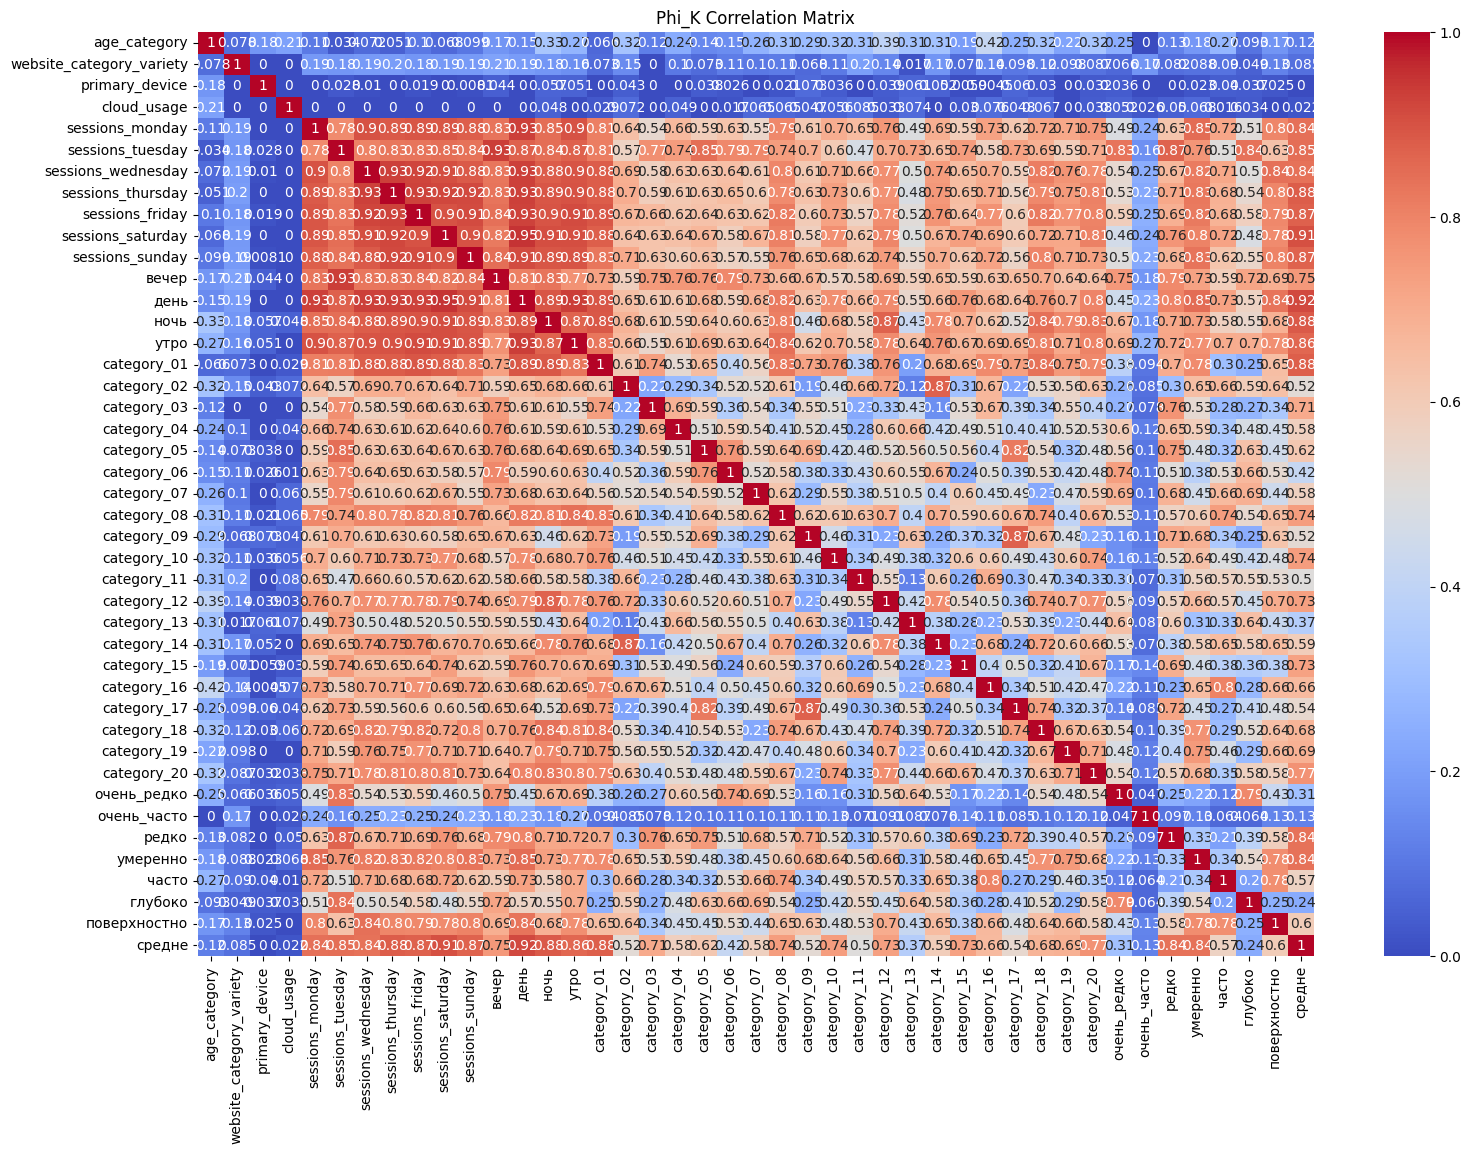

In [37]:
corr_matrix = df_copy.phik_matrix(interval_cols=num_features_heatmap)

plt.figure(figsize=(18, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'>Здорово,что применена `phik` для анализа и нелинейных зависимостей</font>

In [38]:
high_corr = corr_matrix[(corr_matrix > 0.8) & (corr_matrix < 1)]
display("Пары признаков с корреляцией > 0.8:")
display(high_corr.unstack().dropna().sort_values(ascending=False))

'Пары признаков с корреляцией > 0.8:'

sessions_saturday  день                 0.951031
день               sessions_saturday    0.951031
вечер              sessions_tuesday     0.934118
sessions_tuesday   вечер                0.934118
утро               день                 0.933805
                                          ...   
category_20        sessions_friday      0.802860
поверхностно       sessions_sunday      0.802480
sessions_sunday    поверхностно         0.802480
                   category_18          0.800302
category_18        sessions_sunday      0.800302
Length: 224, dtype: float64

Признаков достаточно много, поэтому буду пытаться сократить их число с помощью методов-оберток

---
**Выбросы**

In [39]:
def drawHist(feature_name, df=df):
    feature = df[feature_name]
    
    title = f'Гистограмма {feature_name}'
    x_label = feature_name
    y_label = 'Число кликов'

    plt.hist(feature, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    plt.title(title)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.axvline(feature.mean(), color='red', linestyle='--', alpha=0.8, label=f'Среднее: {feature.mean():.2f}')
    plt.axvline(feature.median(), color='green', linestyle='--', alpha=0.8, label=f'Медиана: {feature.median():.2f}')
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"Статистика для {feature_name}:")
    print(f"  Среднее: {feature.mean():.2f}")
    print(f"  Медиана: {feature.median():.2f}")
    print(f"  Стандартное отклонение: {feature.std():.2f}")
    print(f"  Минимум: {feature.min():.2f}")
    print(f"  Максимум: {feature.max():.2f}")
    print(f"  Пропусков: {df[feature_name].isnull().sum()} ({df[feature_name].isnull().mean():.1%})")

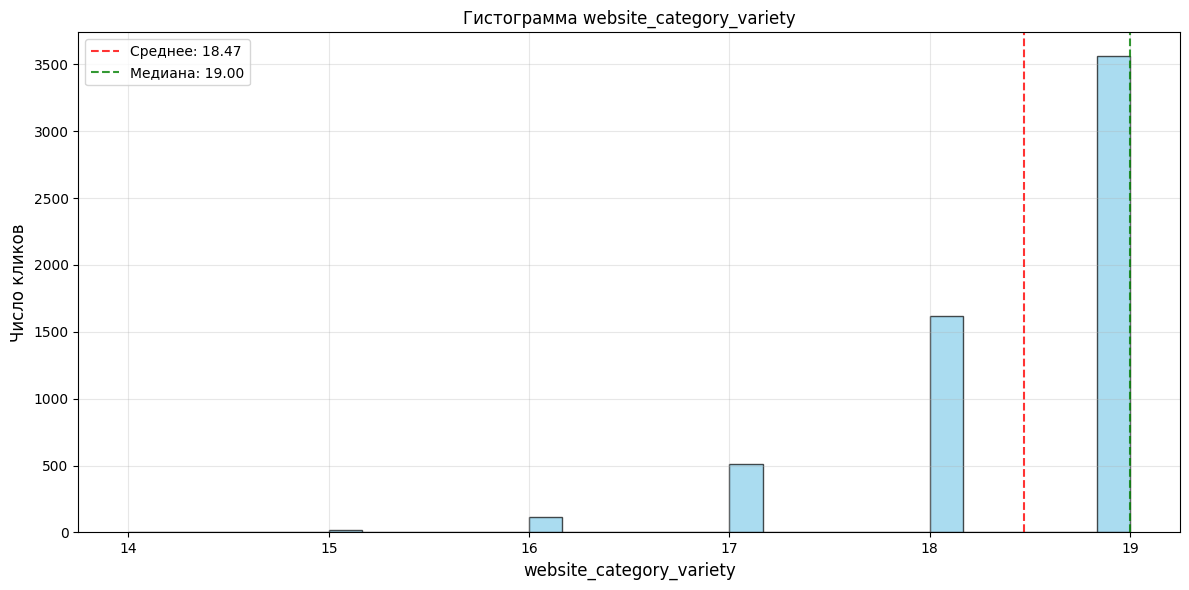

Статистика для website_category_variety:
  Среднее: 18.47
  Медиана: 19.00
  Стандартное отклонение: 0.77
  Минимум: 14.00
  Максимум: 19.00
  Пропусков: 0 (0.0%)


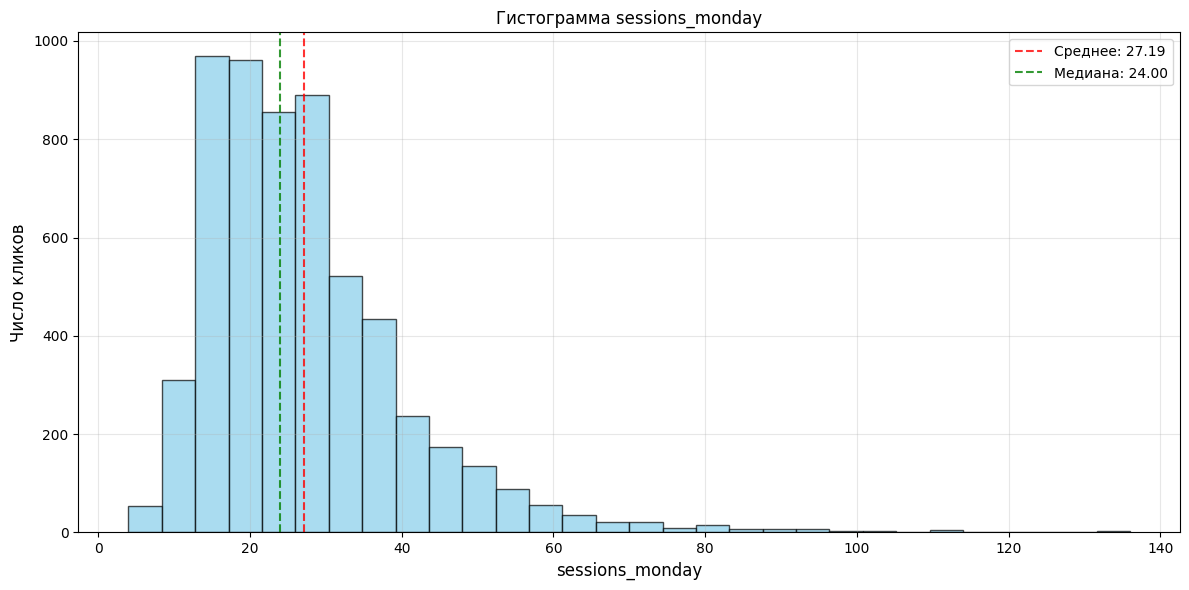

Статистика для sessions_monday:
  Среднее: 27.19
  Медиана: 24.00
  Стандартное отклонение: 13.55
  Минимум: 4.00
  Максимум: 136.00
  Пропусков: 0 (0.0%)


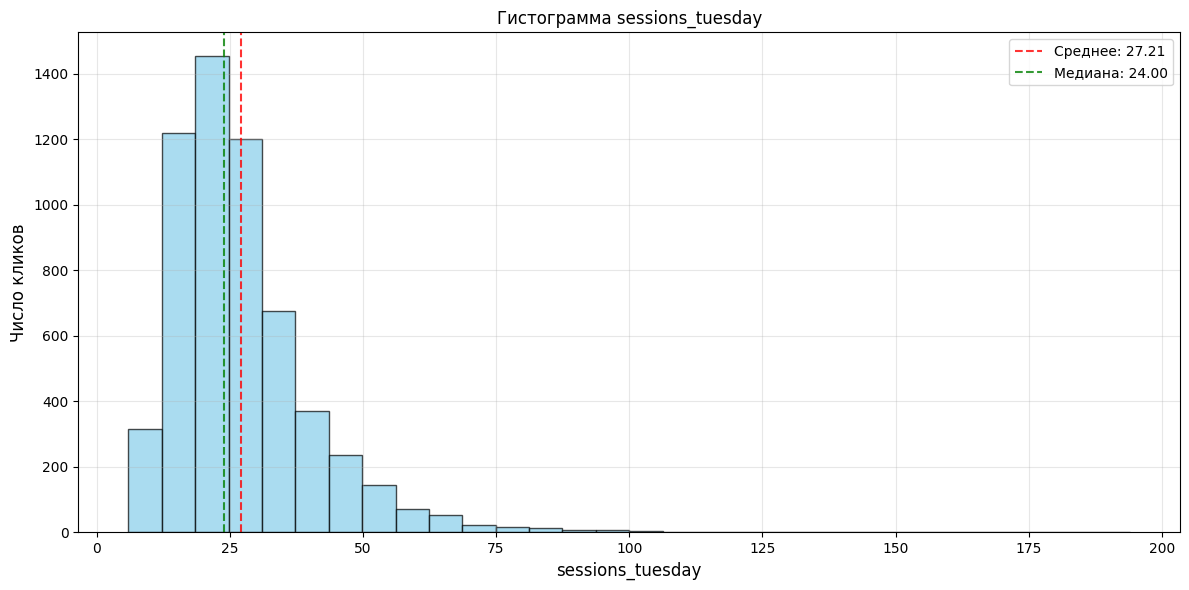

Статистика для sessions_tuesday:
  Среднее: 27.21
  Медиана: 24.00
  Стандартное отклонение: 13.45
  Минимум: 6.00
  Максимум: 194.00
  Пропусков: 0 (0.0%)


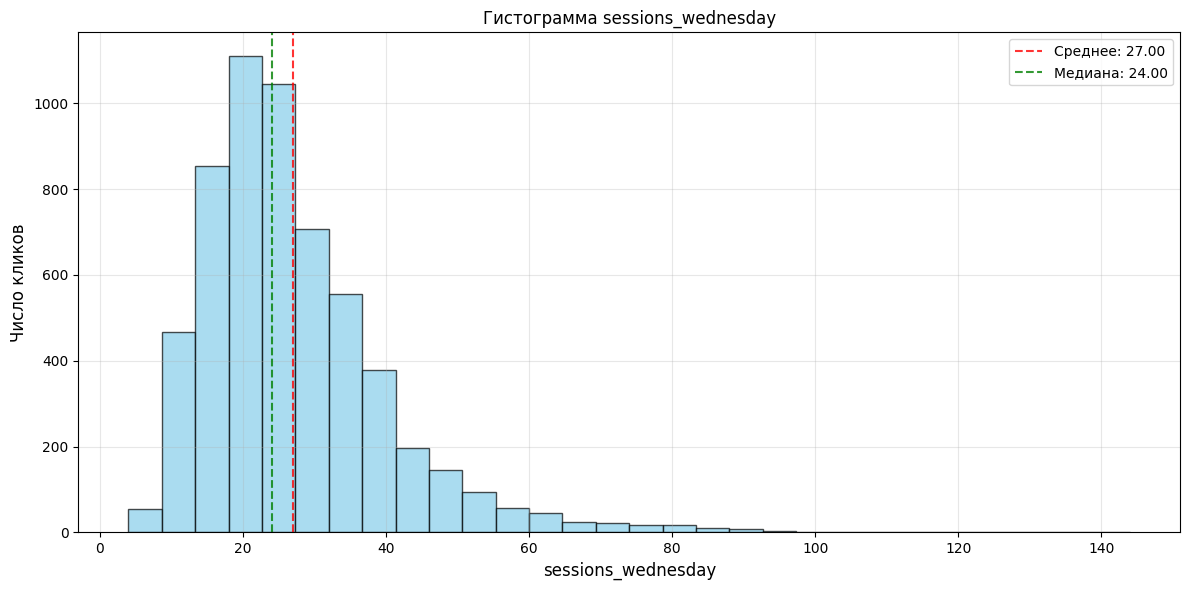

Статистика для sessions_wednesday:
  Среднее: 27.00
  Медиана: 24.00
  Стандартное отклонение: 13.32
  Минимум: 4.00
  Максимум: 144.00
  Пропусков: 0 (0.0%)


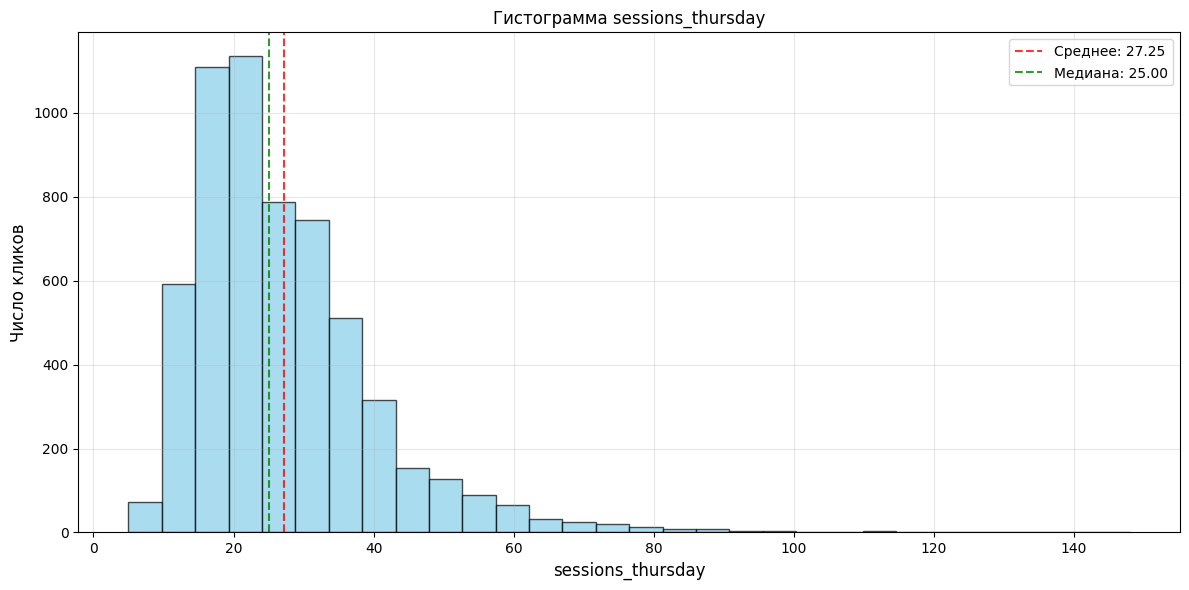

Статистика для sessions_thursday:
  Среднее: 27.25
  Медиана: 25.00
  Стандартное отклонение: 13.37
  Минимум: 5.00
  Максимум: 148.00
  Пропусков: 0 (0.0%)


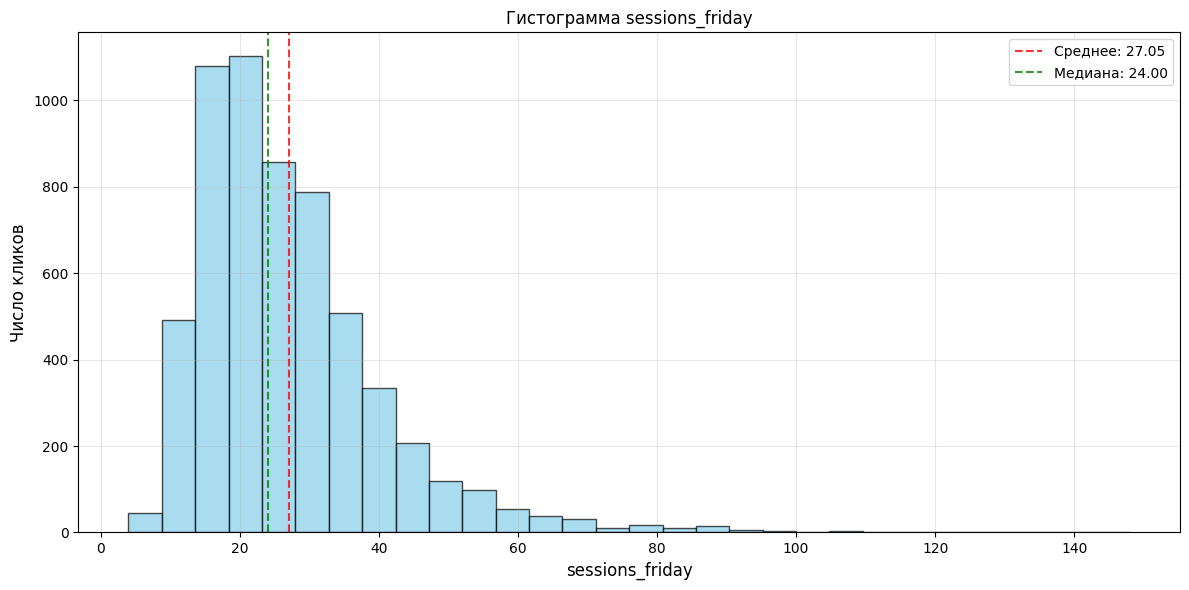

Статистика для sessions_friday:
  Среднее: 27.05
  Медиана: 24.00
  Стандартное отклонение: 13.47
  Минимум: 4.00
  Максимум: 148.00
  Пропусков: 0 (0.0%)


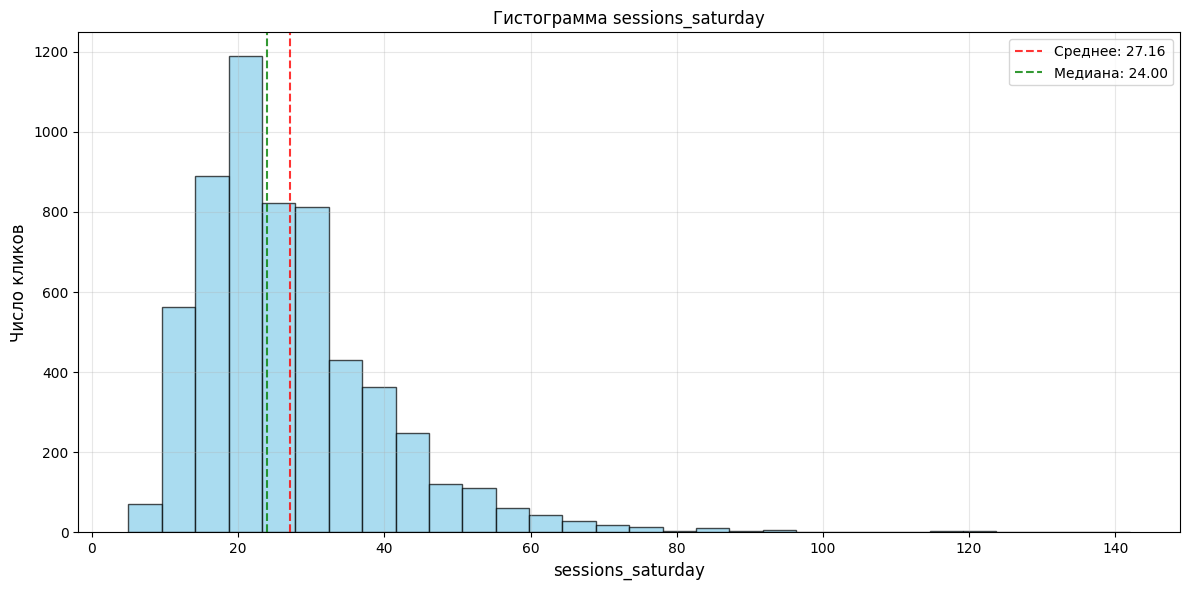

Статистика для sessions_saturday:
  Среднее: 27.16
  Медиана: 24.00
  Стандартное отклонение: 13.16
  Минимум: 5.00
  Максимум: 142.00
  Пропусков: 0 (0.0%)


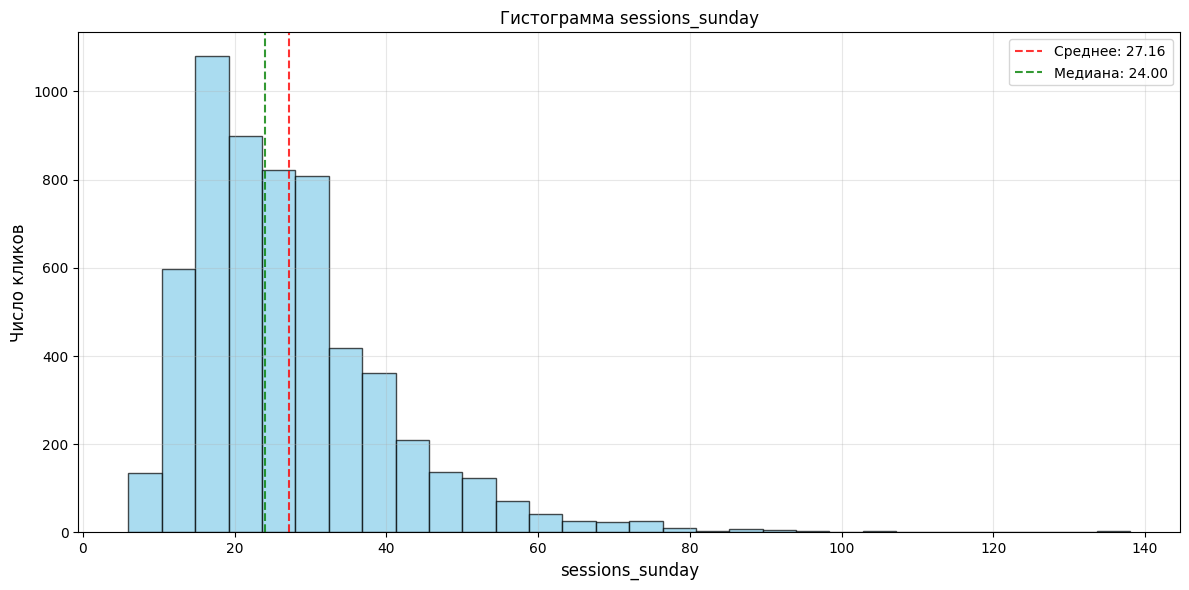

Статистика для sessions_sunday:
  Среднее: 27.16
  Медиана: 24.00
  Стандартное отклонение: 13.45
  Минимум: 6.00
  Максимум: 138.00
  Пропусков: 0 (0.0%)


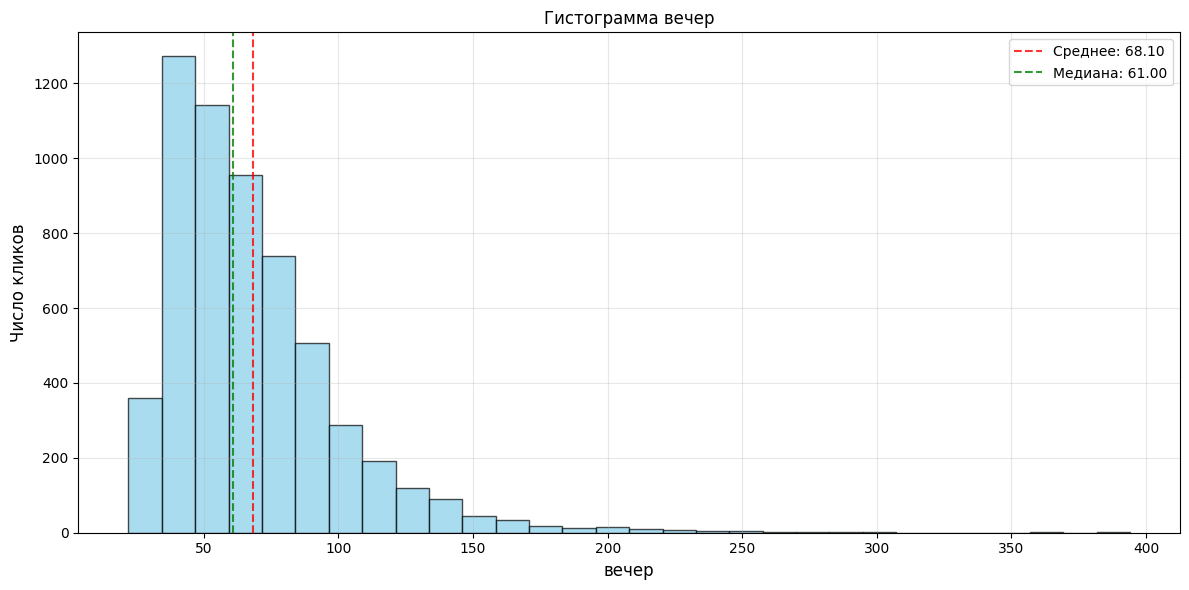

Статистика для вечер:
  Среднее: 68.10
  Медиана: 61.00
  Стандартное отклонение: 32.66
  Минимум: 22.00
  Максимум: 394.00
  Пропусков: 0 (0.0%)


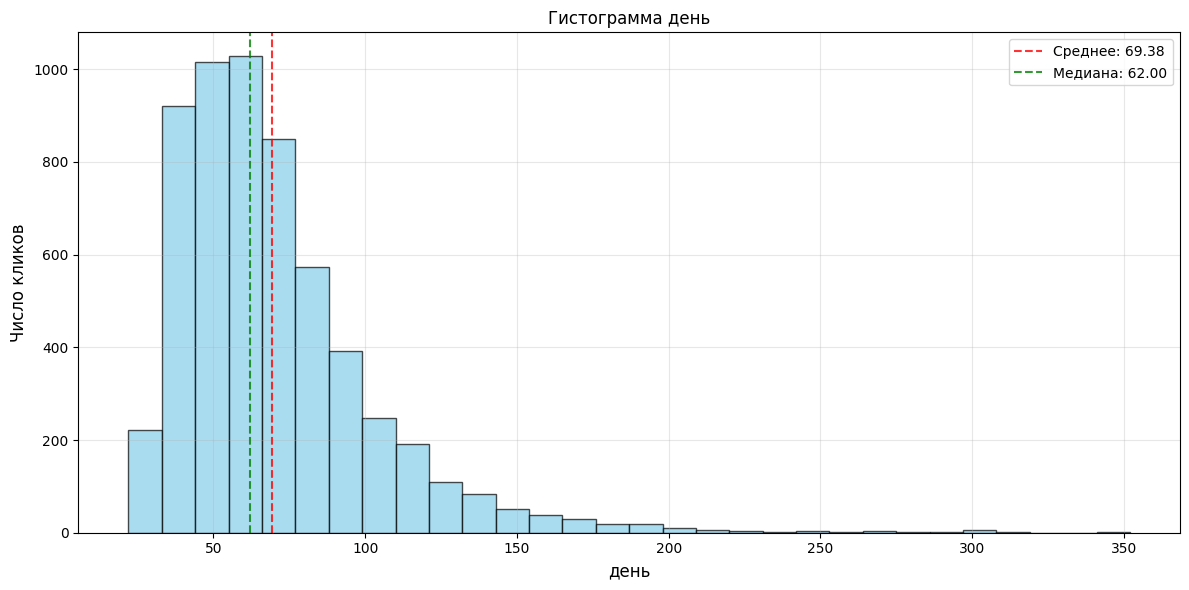

Статистика для день:
  Среднее: 69.38
  Медиана: 62.00
  Стандартное отклонение: 32.65
  Минимум: 22.00
  Максимум: 352.00
  Пропусков: 0 (0.0%)


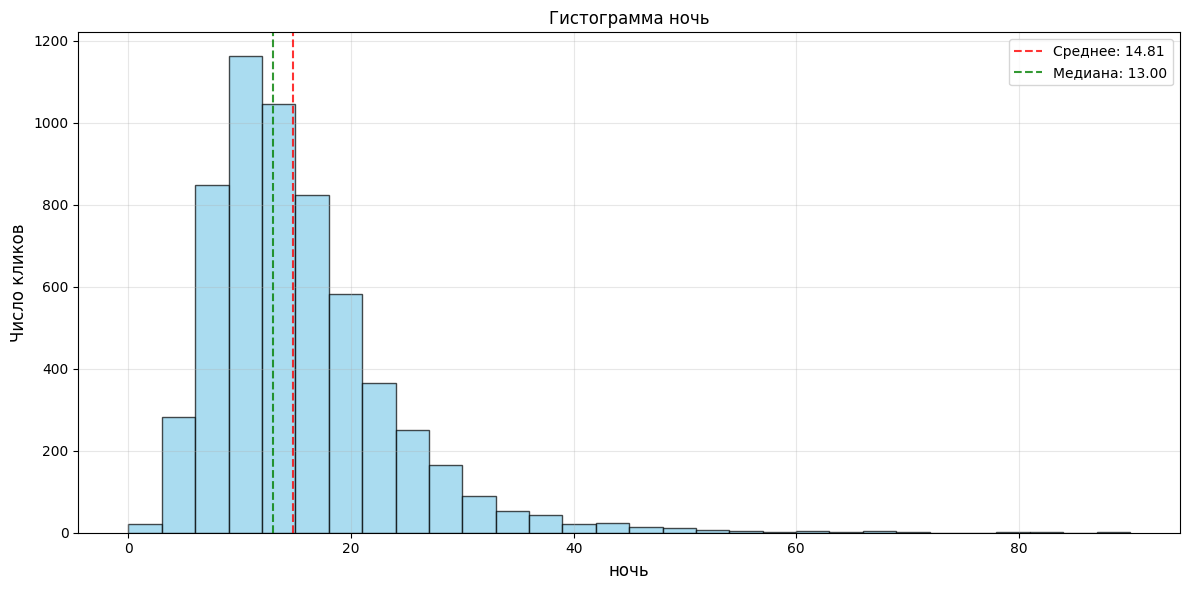

Статистика для ночь:
  Среднее: 14.81
  Медиана: 13.00
  Стандартное отклонение: 8.10
  Минимум: 0.00
  Максимум: 90.00
  Пропусков: 0 (0.0%)


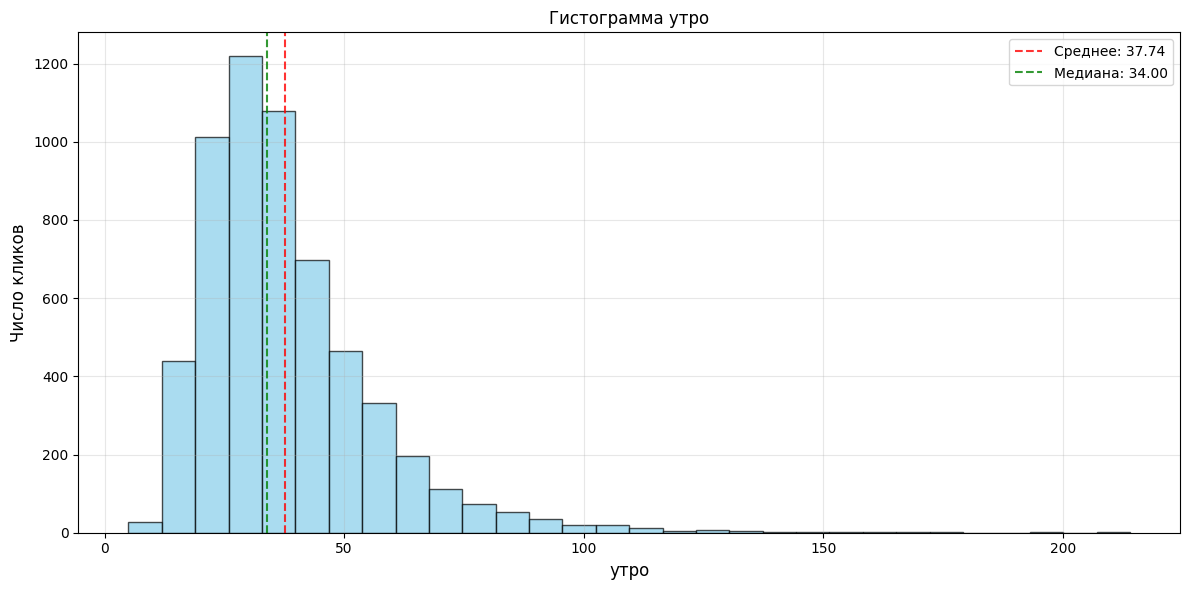

Статистика для утро:
  Среднее: 37.74
  Медиана: 34.00
  Стандартное отклонение: 18.62
  Минимум: 5.00
  Максимум: 214.00
  Пропусков: 0 (0.0%)


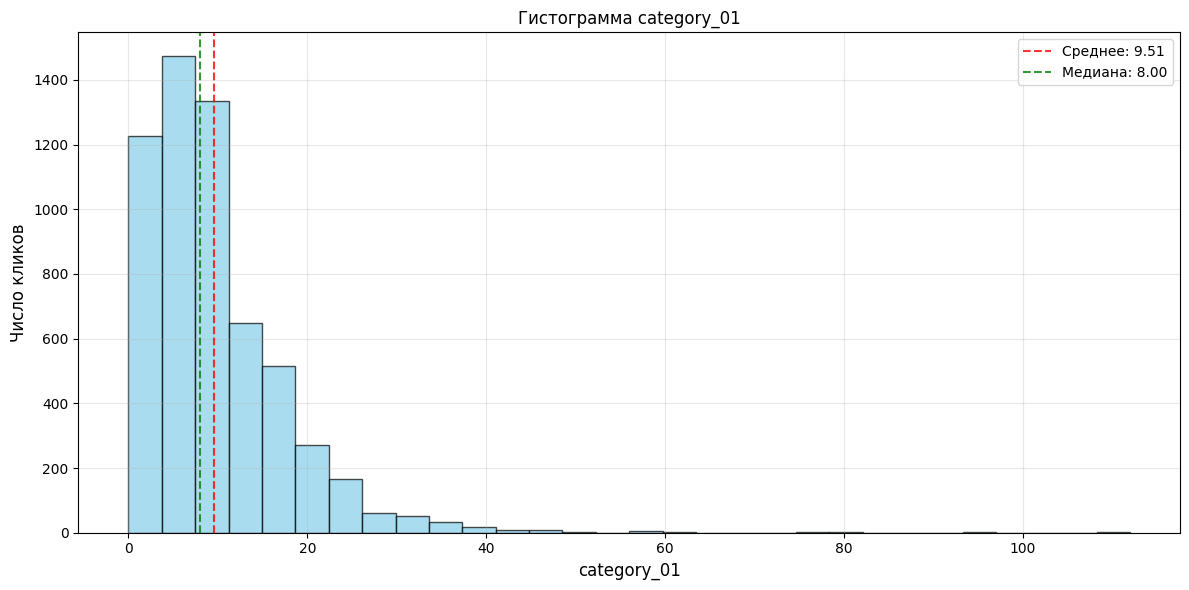

Статистика для category_01:
  Среднее: 9.51
  Медиана: 8.00
  Стандартное отклонение: 7.81
  Минимум: 0.00
  Максимум: 112.00
  Пропусков: 0 (0.0%)


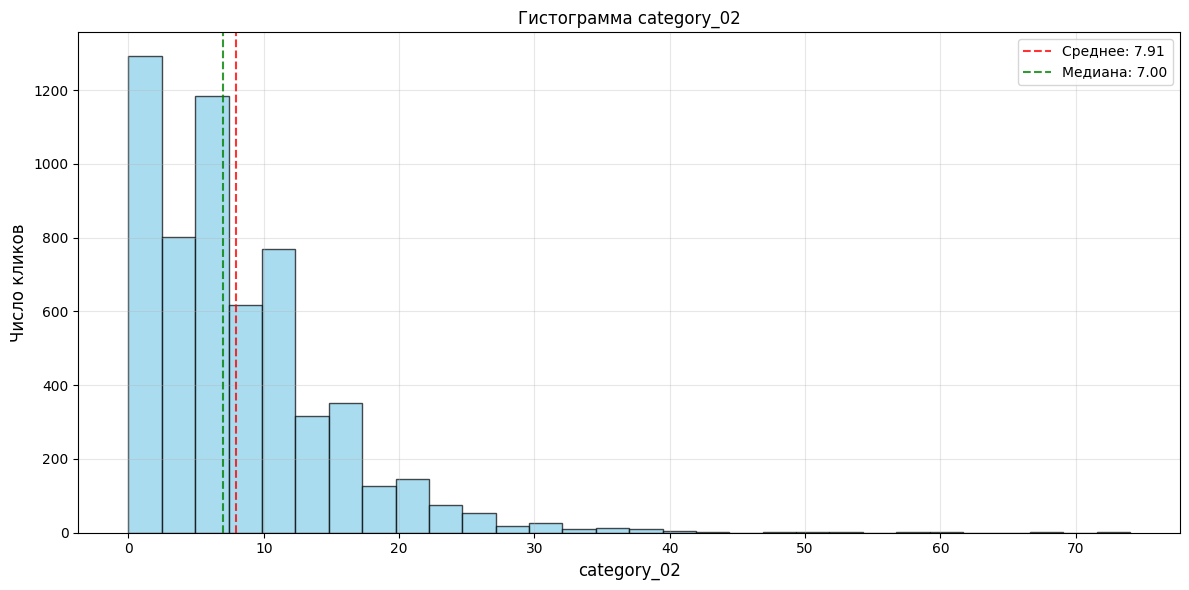

Статистика для category_02:
  Среднее: 7.91
  Медиана: 7.00
  Стандартное отклонение: 6.89
  Минимум: 0.00
  Максимум: 74.00
  Пропусков: 0 (0.0%)


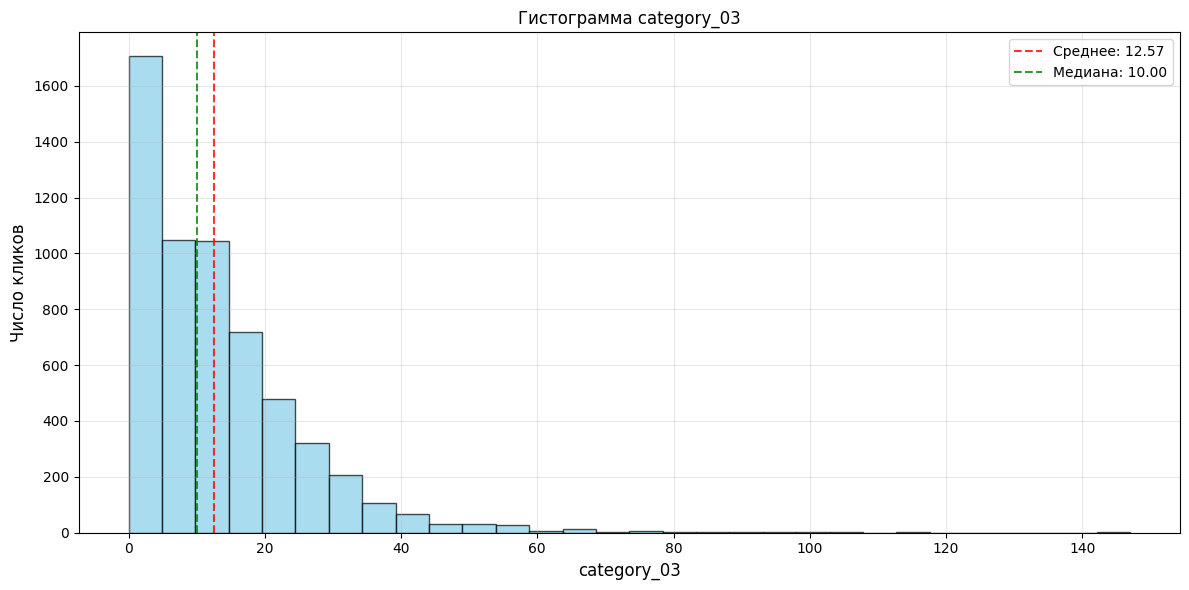

Статистика для category_03:
  Среднее: 12.57
  Медиана: 10.00
  Стандартное отклонение: 12.30
  Минимум: 0.00
  Максимум: 147.00
  Пропусков: 0 (0.0%)


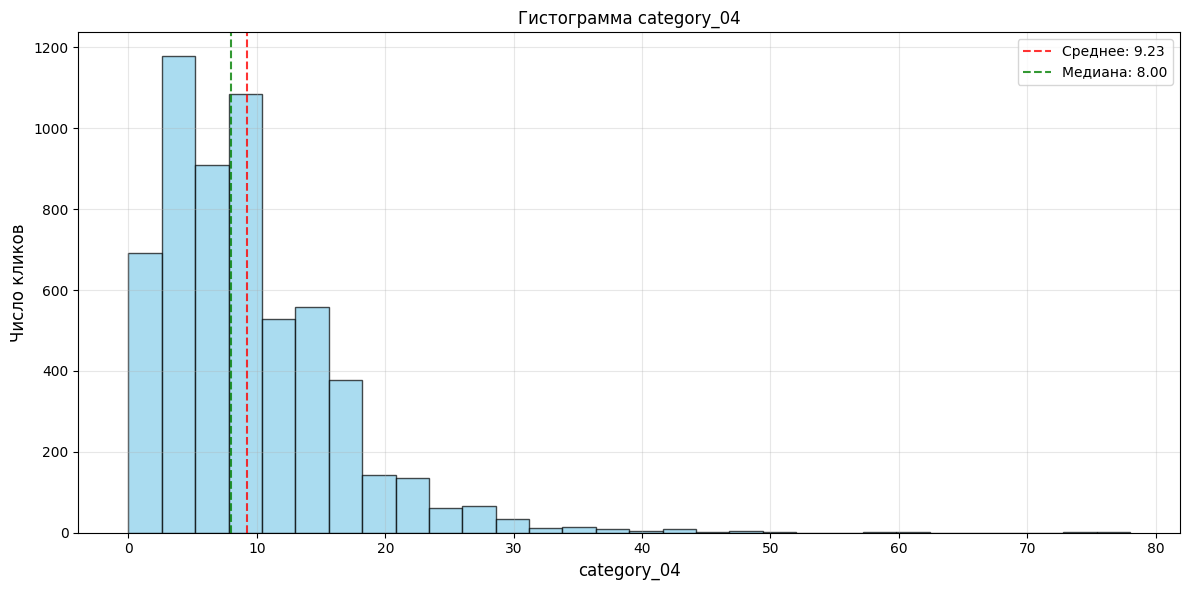

Статистика для category_04:
  Среднее: 9.23
  Медиана: 8.00
  Стандартное отклонение: 6.92
  Минимум: 0.00
  Максимум: 78.00
  Пропусков: 0 (0.0%)


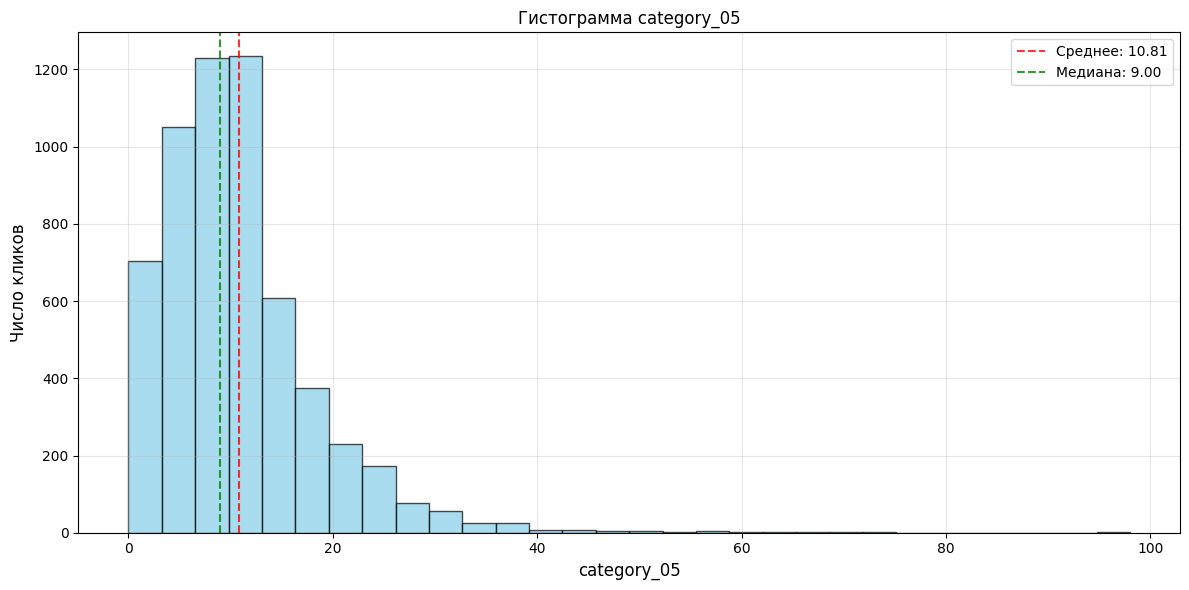

Статистика для category_05:
  Среднее: 10.81
  Медиана: 9.00
  Стандартное отклонение: 7.69
  Минимум: 0.00
  Максимум: 98.00
  Пропусков: 0 (0.0%)


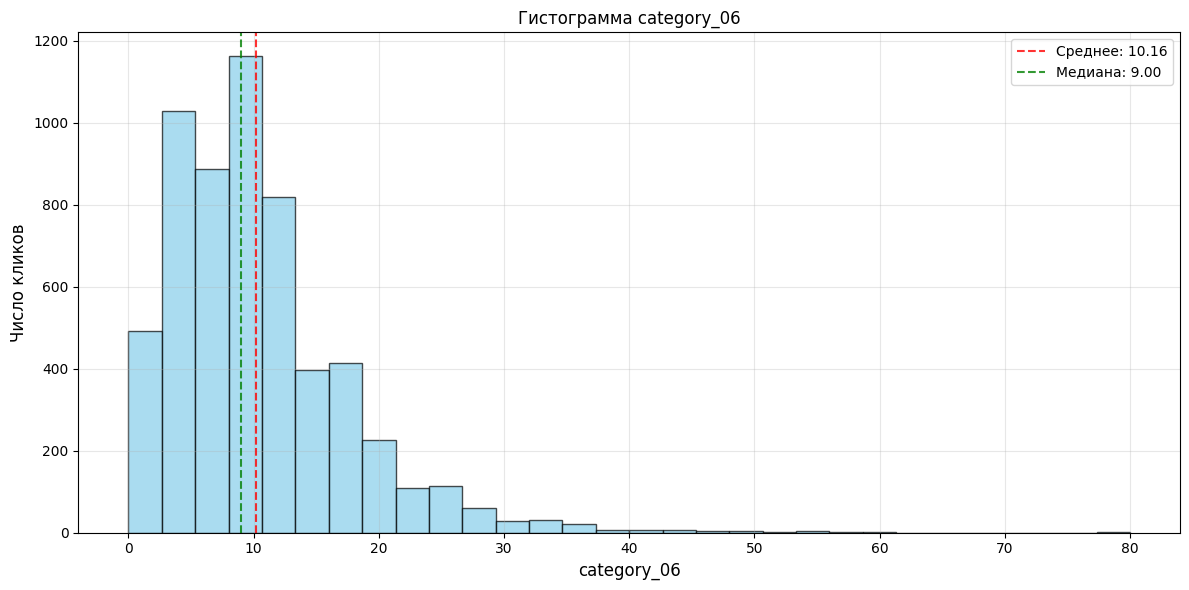

Статистика для category_06:
  Среднее: 10.16
  Медиана: 9.00
  Стандартное отклонение: 7.14
  Минимум: 0.00
  Максимум: 80.00
  Пропусков: 0 (0.0%)


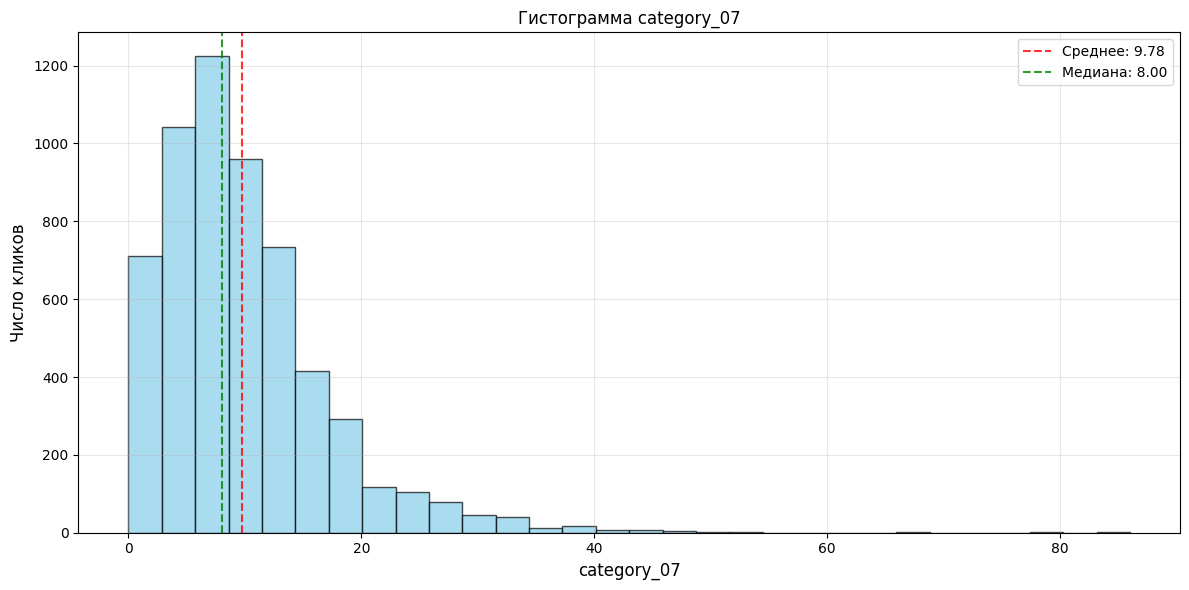

Статистика для category_07:
  Среднее: 9.78
  Медиана: 8.00
  Стандартное отклонение: 7.42
  Минимум: 0.00
  Максимум: 86.00
  Пропусков: 0 (0.0%)


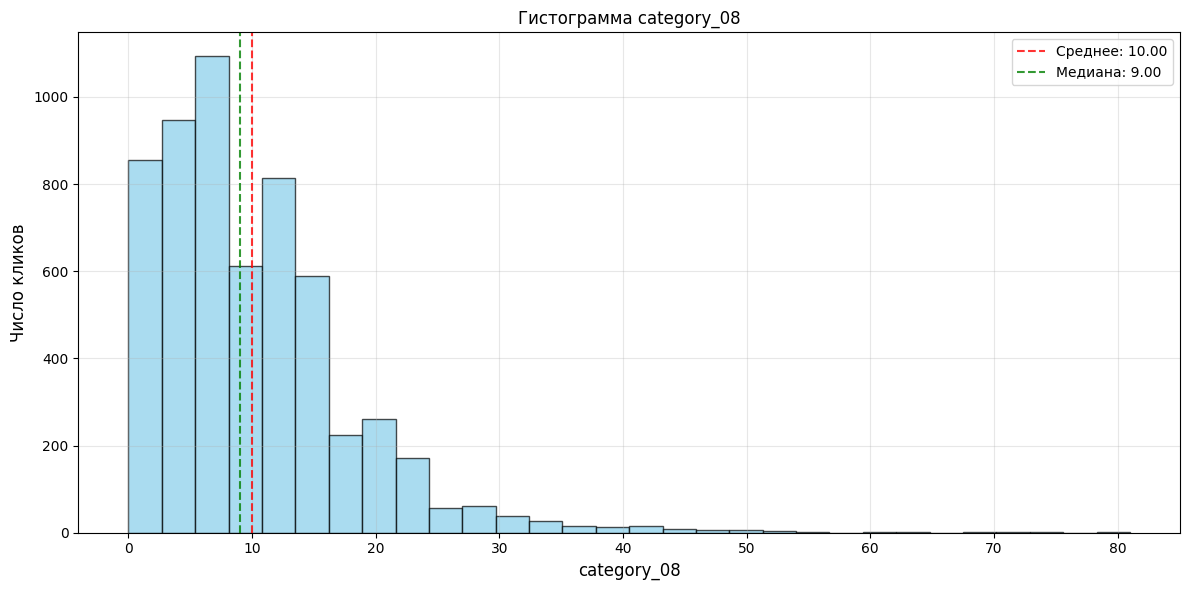

Статистика для category_08:
  Среднее: 10.00
  Медиана: 9.00
  Стандартное отклонение: 7.90
  Минимум: 0.00
  Максимум: 81.00
  Пропусков: 0 (0.0%)


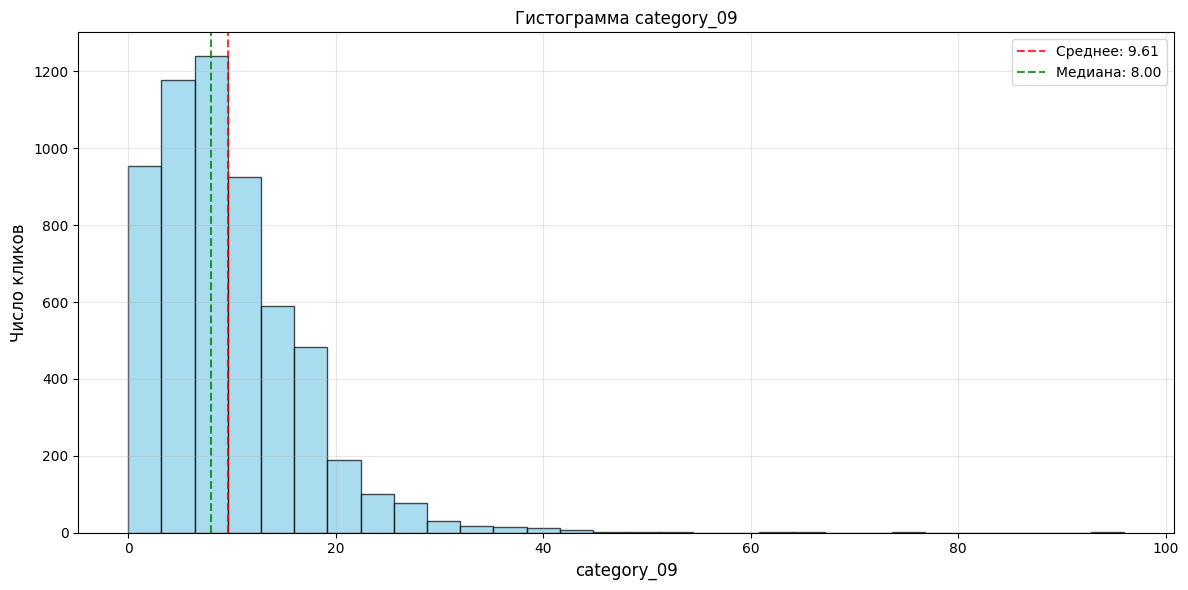

Статистика для category_09:
  Среднее: 9.61
  Медиана: 8.00
  Стандартное отклонение: 6.98
  Минимум: 0.00
  Максимум: 96.00
  Пропусков: 0 (0.0%)


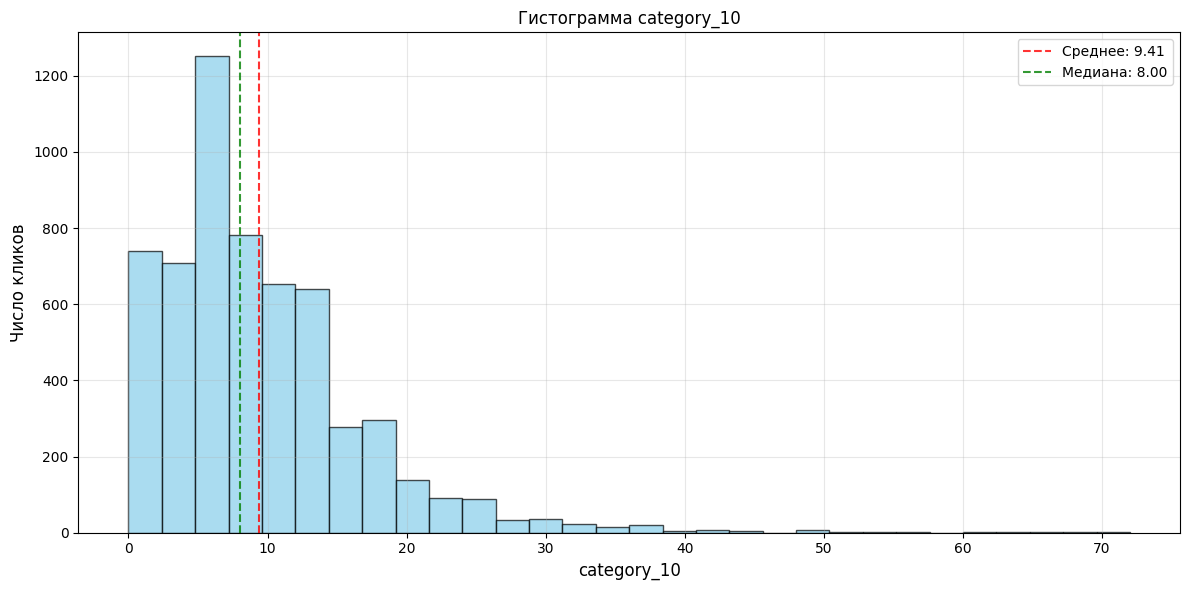

Статистика для category_10:
  Среднее: 9.41
  Медиана: 8.00
  Стандартное отклонение: 7.25
  Минимум: 0.00
  Максимум: 72.00
  Пропусков: 0 (0.0%)


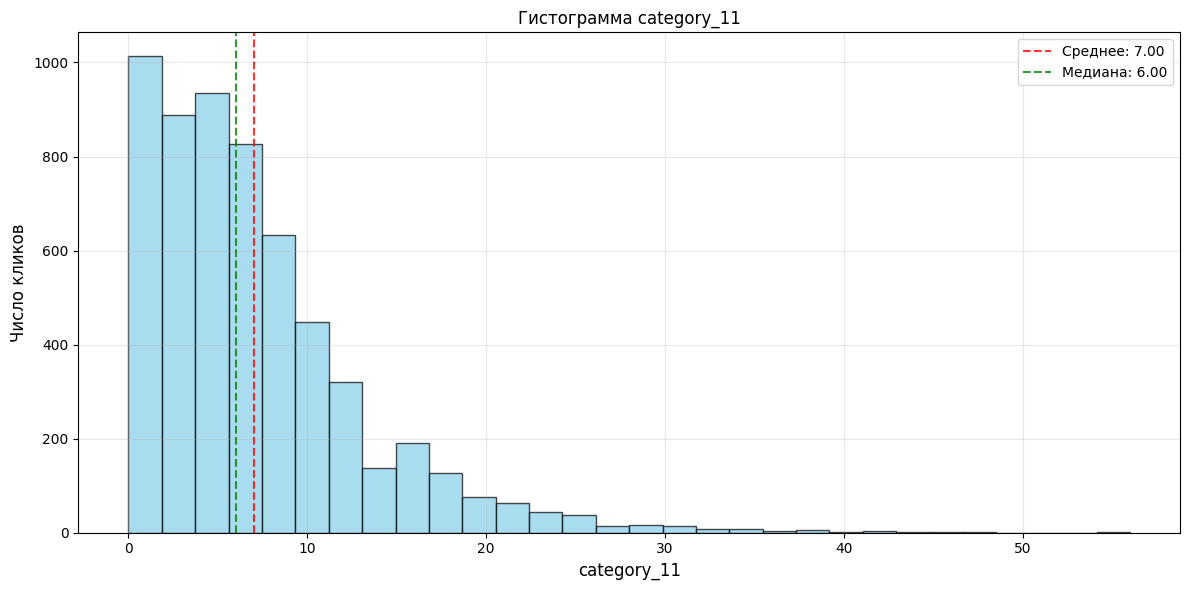

Статистика для category_11:
  Среднее: 7.00
  Медиана: 6.00
  Стандартное отклонение: 6.24
  Минимум: 0.00
  Максимум: 56.00
  Пропусков: 0 (0.0%)


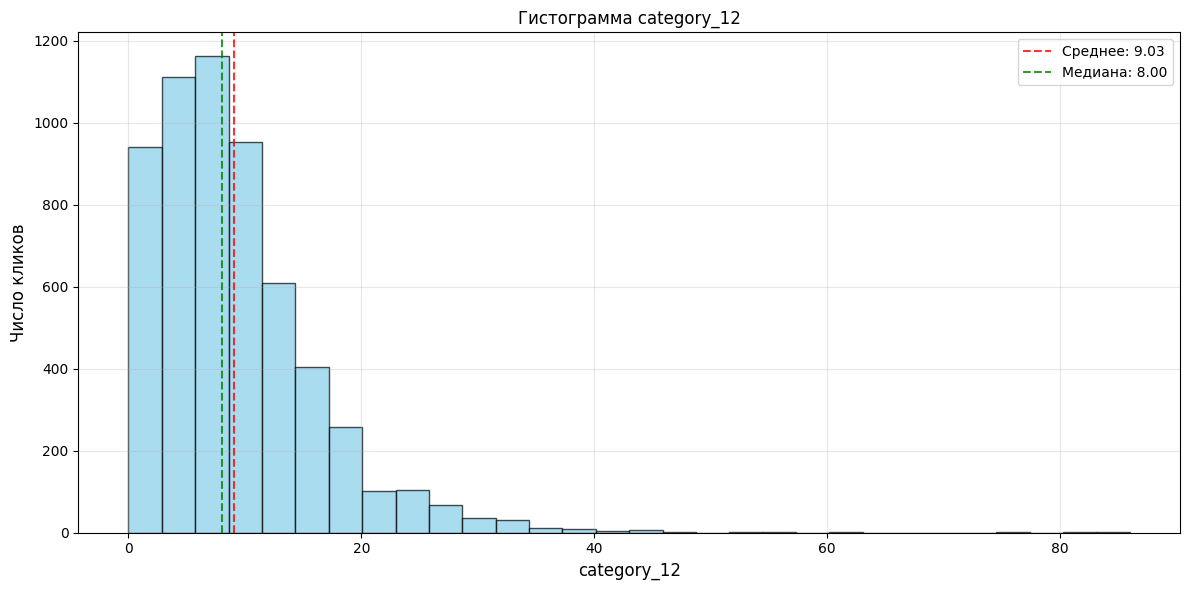

Статистика для category_12:
  Среднее: 9.03
  Медиана: 8.00
  Стандартное отклонение: 7.40
  Минимум: 0.00
  Максимум: 86.00
  Пропусков: 0 (0.0%)


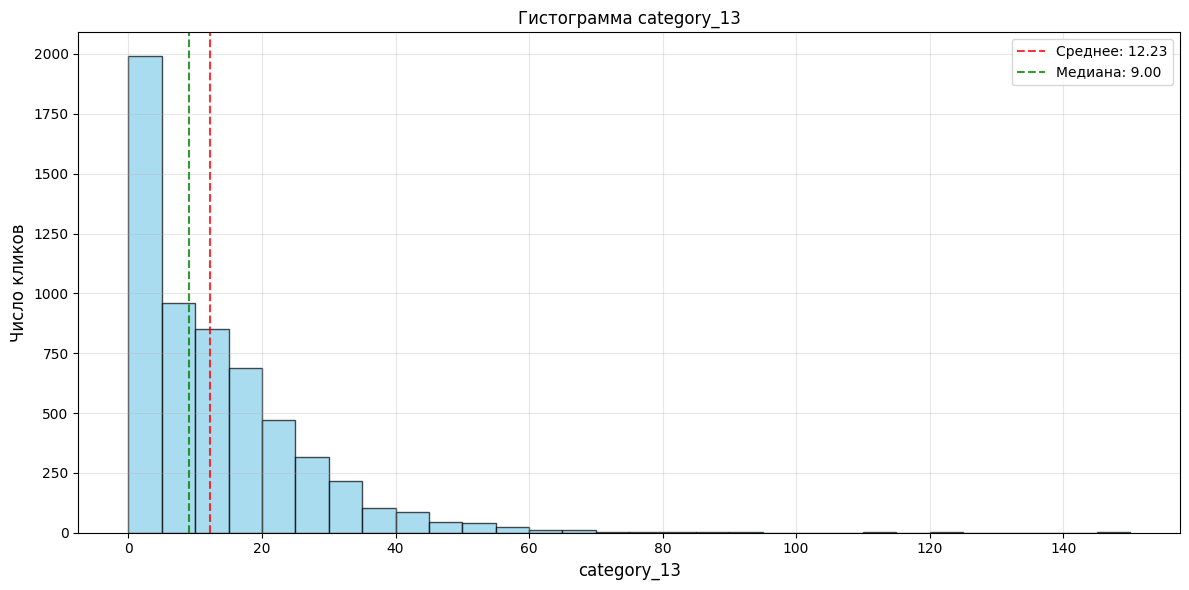

Статистика для category_13:
  Среднее: 12.23
  Медиана: 9.00
  Стандартное отклонение: 12.78
  Минимум: 0.00
  Максимум: 150.00
  Пропусков: 0 (0.0%)


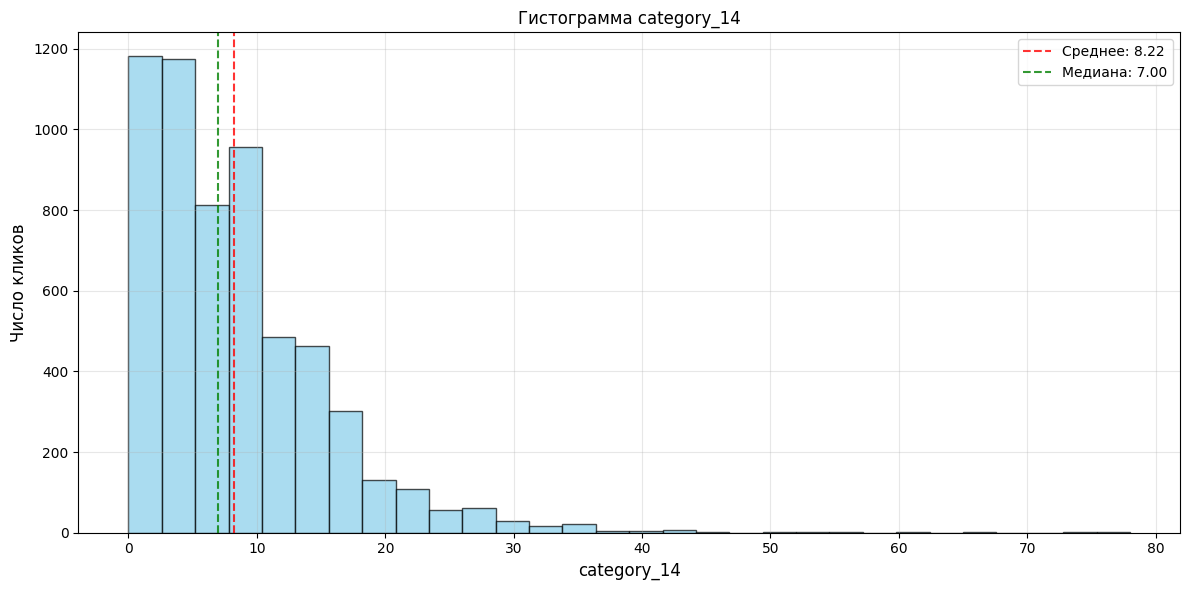

Статистика для category_14:
  Среднее: 8.22
  Медиана: 7.00
  Стандартное отклонение: 7.09
  Минимум: 0.00
  Максимум: 78.00
  Пропусков: 0 (0.0%)


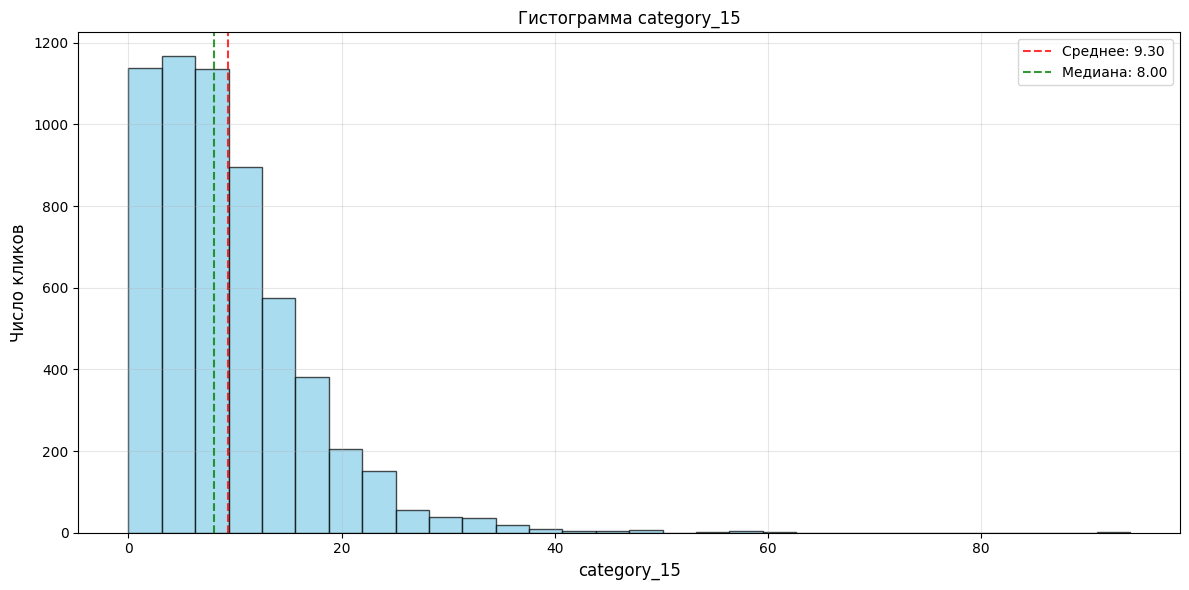

Статистика для category_15:
  Среднее: 9.30
  Медиана: 8.00
  Стандартное отклонение: 7.15
  Минимум: 0.00
  Максимум: 94.00
  Пропусков: 0 (0.0%)


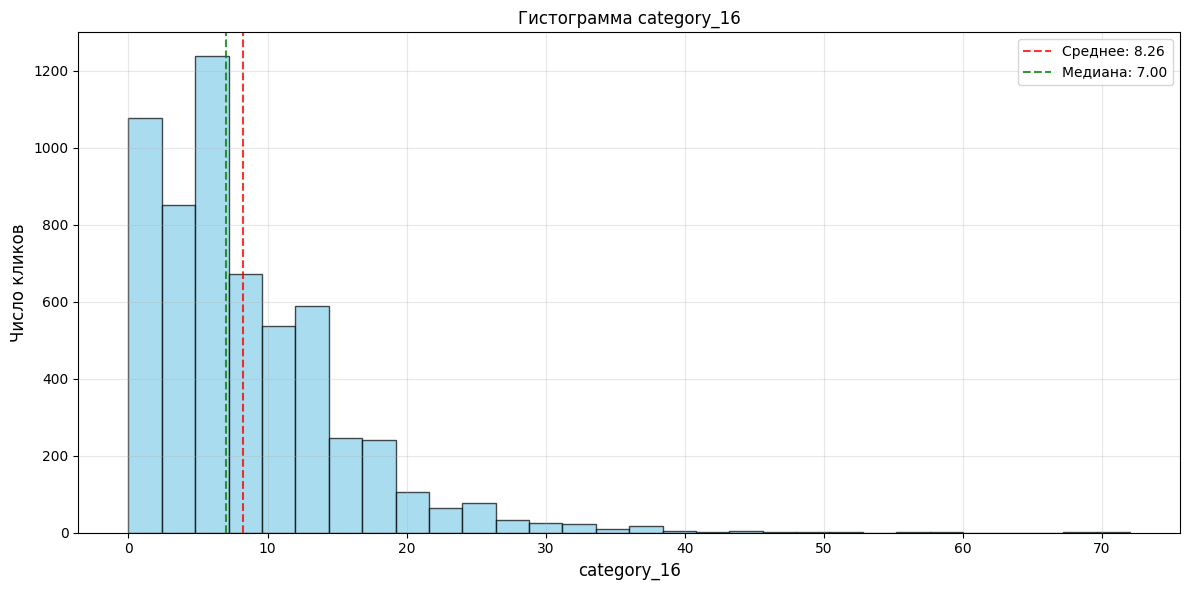

Статистика для category_16:
  Среднее: 8.26
  Медиана: 7.00
  Стандартное отклонение: 6.89
  Минимум: 0.00
  Максимум: 72.00
  Пропусков: 0 (0.0%)


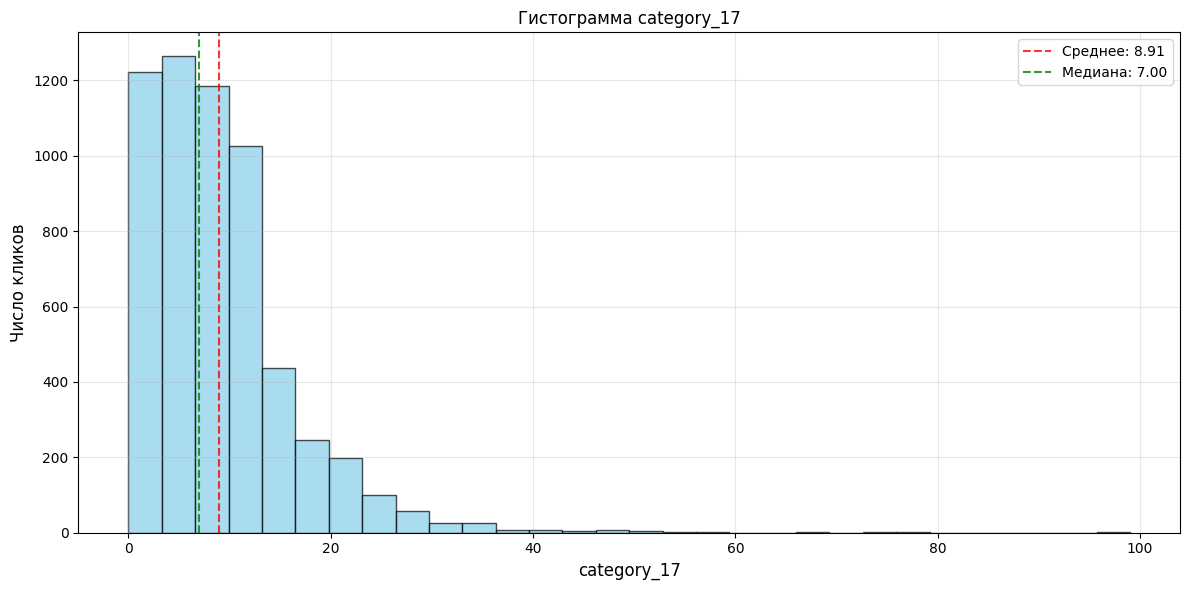

Статистика для category_17:
  Среднее: 8.91
  Медиана: 7.00
  Стандартное отклонение: 7.24
  Минимум: 0.00
  Максимум: 99.00
  Пропусков: 0 (0.0%)


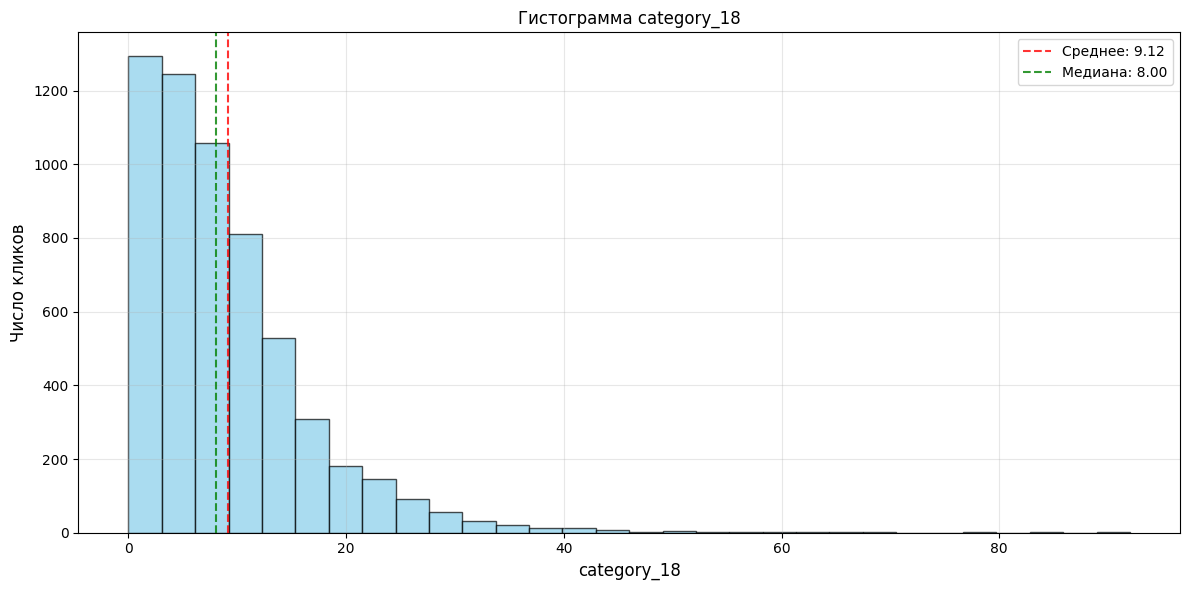

Статистика для category_18:
  Среднее: 9.12
  Медиана: 8.00
  Стандартное отклонение: 7.73
  Минимум: 0.00
  Максимум: 92.00
  Пропусков: 0 (0.0%)


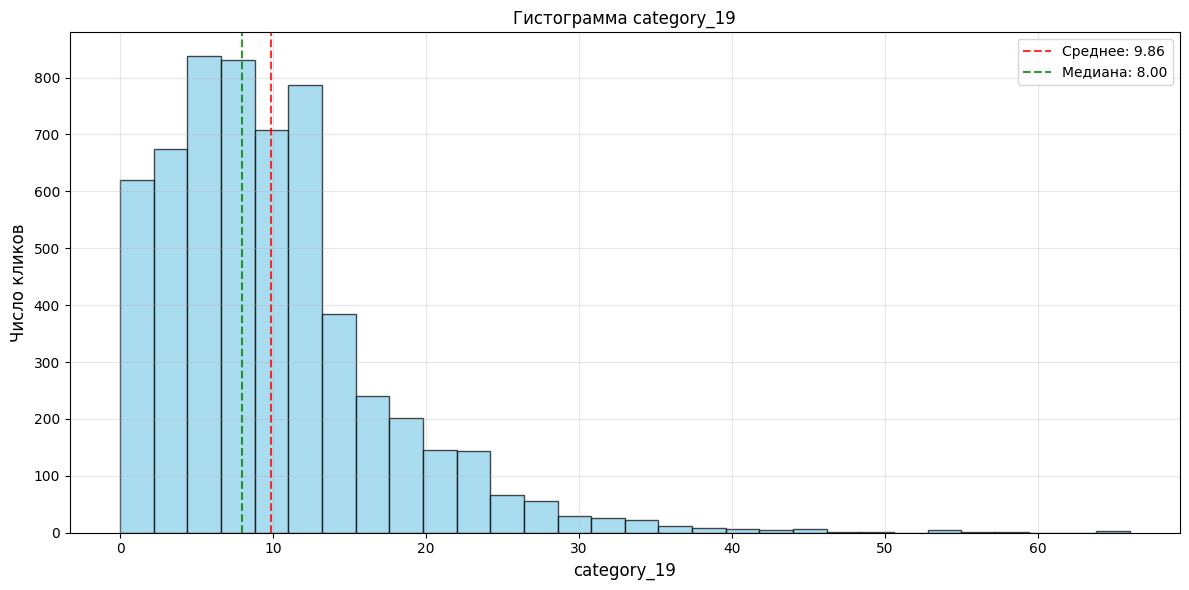

Статистика для category_19:
  Среднее: 9.86
  Медиана: 8.00
  Стандартное отклонение: 7.29
  Минимум: 0.00
  Максимум: 66.00
  Пропусков: 0 (0.0%)


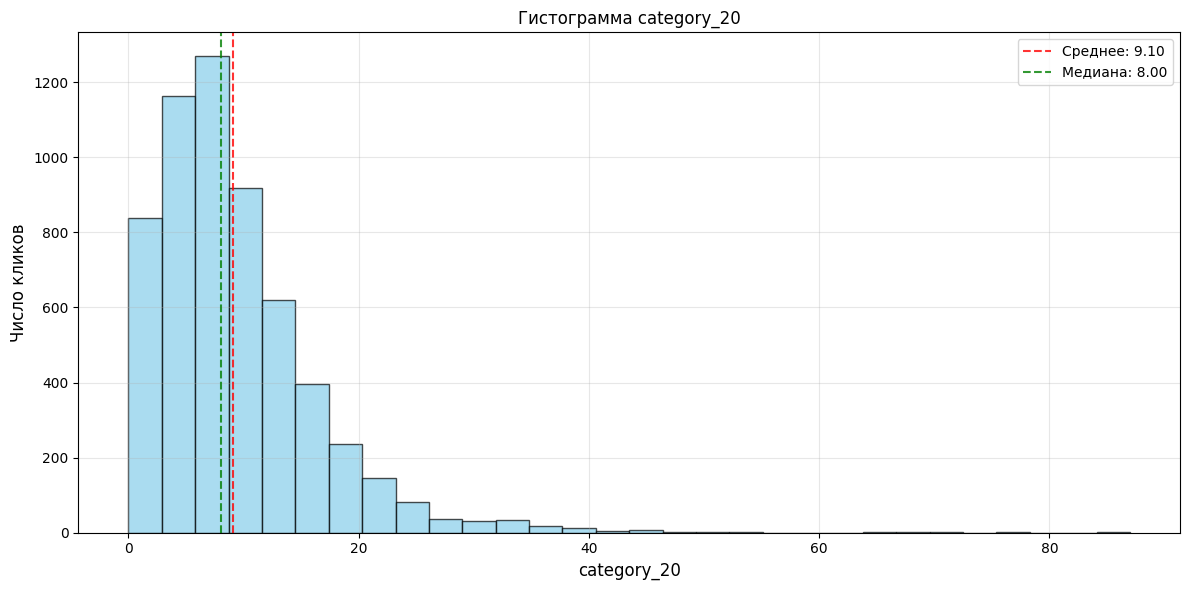

Статистика для category_20:
  Среднее: 9.10
  Медиана: 8.00
  Стандартное отклонение: 7.24
  Минимум: 0.00
  Максимум: 87.00
  Пропусков: 0 (0.0%)


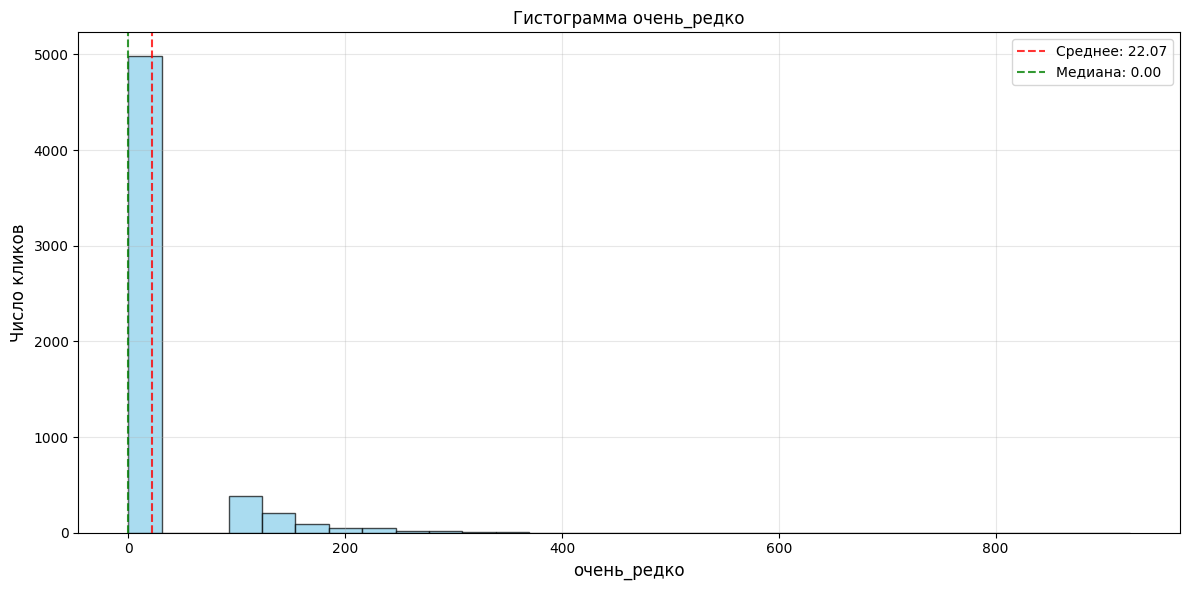

Статистика для очень_редко:
  Среднее: 22.07
  Медиана: 0.00
  Стандартное отклонение: 60.17
  Минимум: 0.00
  Максимум: 924.00
  Пропусков: 0 (0.0%)


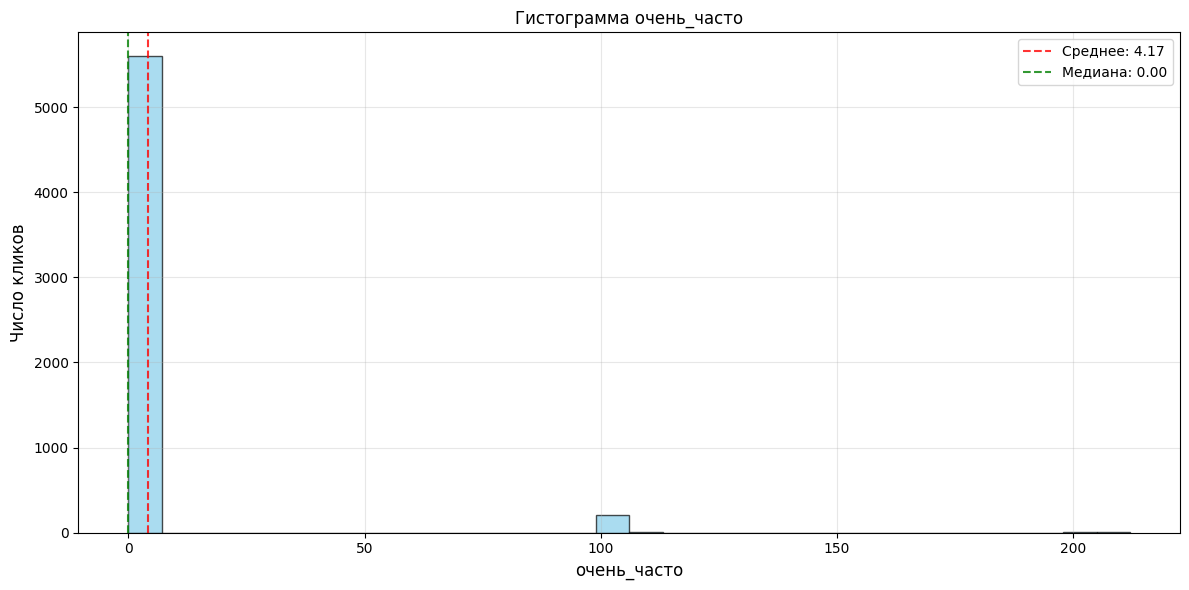

Статистика для очень_часто:
  Среднее: 4.17
  Медиана: 0.00
  Стандартное отклонение: 21.32
  Минимум: 0.00
  Максимум: 212.00
  Пропусков: 0 (0.0%)


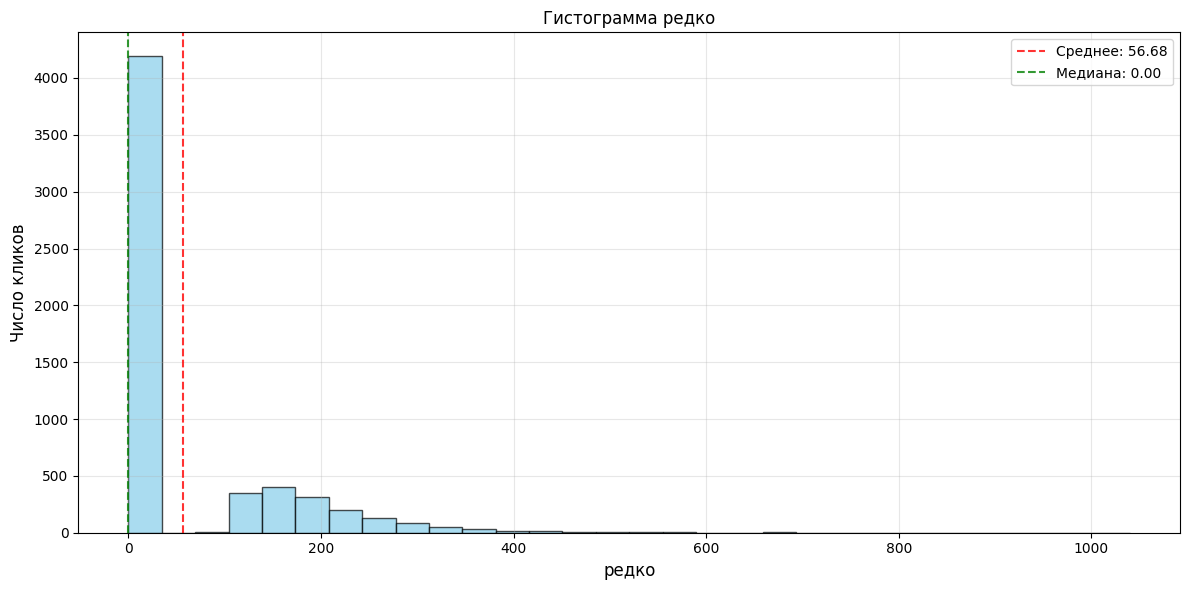

Статистика для редко:
  Среднее: 56.68
  Медиана: 0.00
  Стандартное отклонение: 102.09
  Минимум: 0.00
  Максимум: 1040.00
  Пропусков: 0 (0.0%)


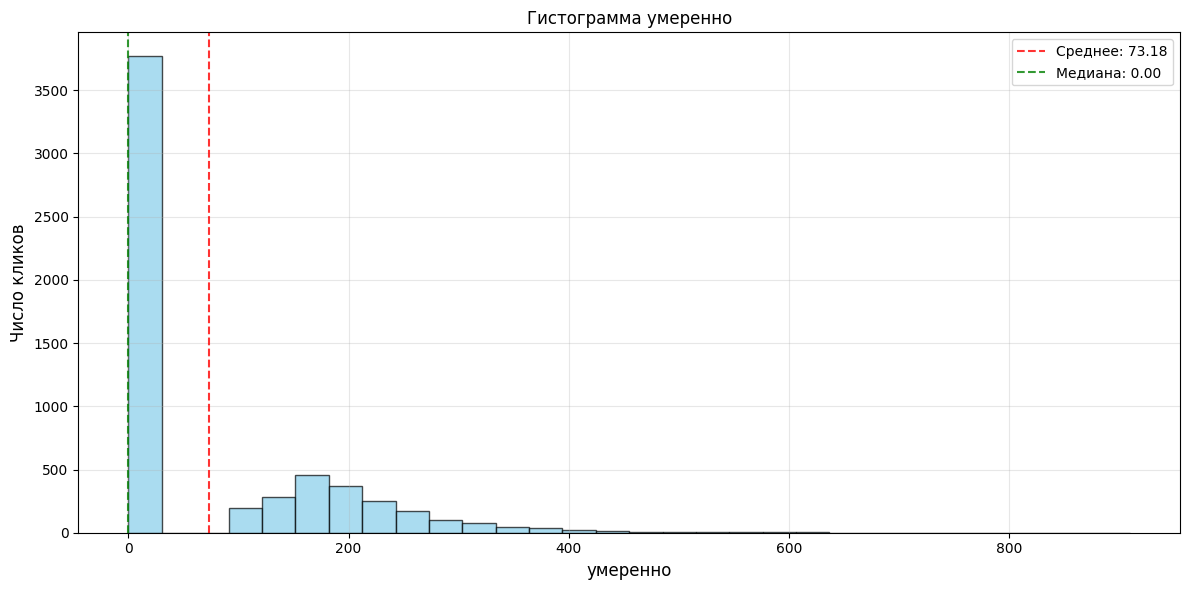

Статистика для умеренно:
  Среднее: 73.18
  Медиана: 0.00
  Стандартное отклонение: 111.25
  Минимум: 0.00
  Максимум: 910.00
  Пропусков: 0 (0.0%)


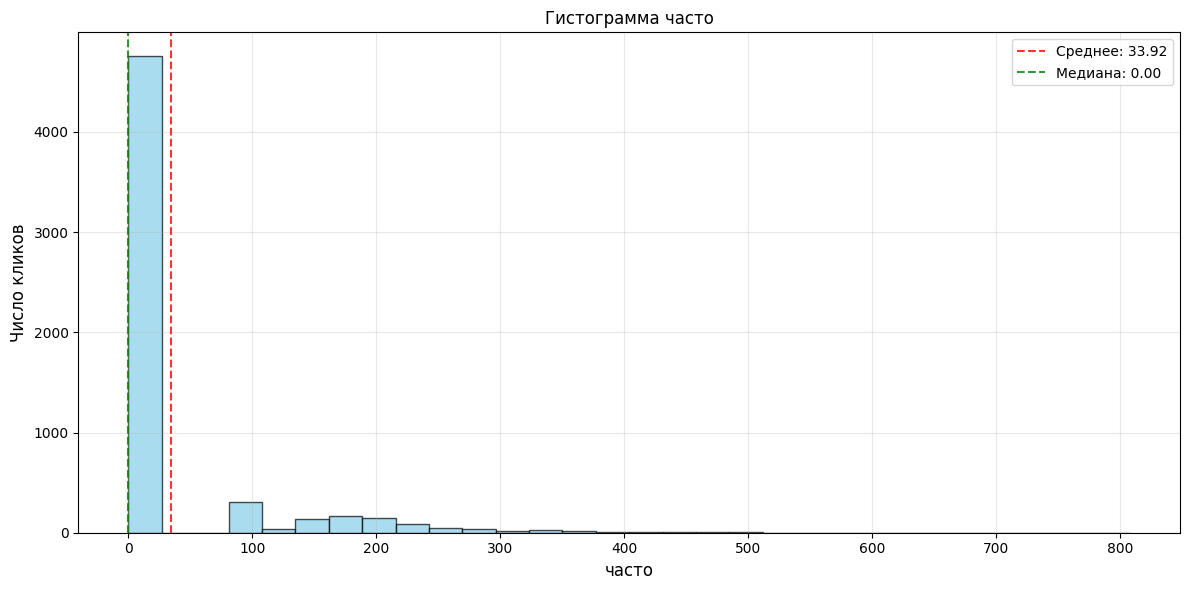

Статистика для часто:
  Среднее: 33.92
  Медиана: 0.00
  Стандартное отклонение: 80.82
  Минимум: 0.00
  Максимум: 808.00
  Пропусков: 0 (0.0%)


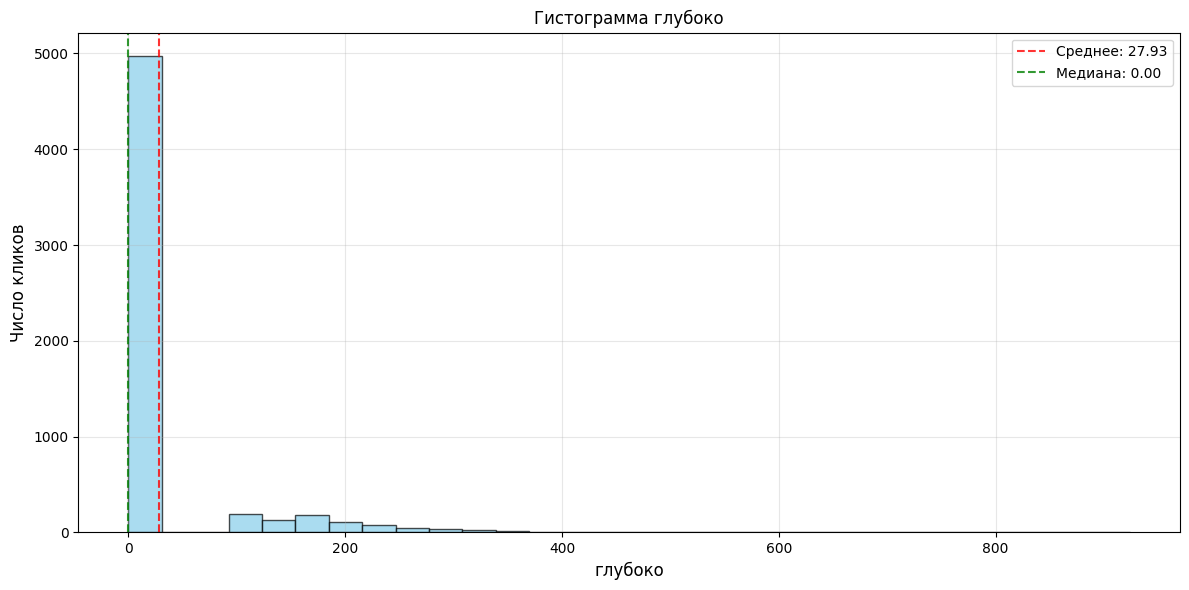

Статистика для глубоко:
  Среднее: 27.93
  Медиана: 0.00
  Стандартное отклонение: 74.90
  Минимум: 0.00
  Максимум: 924.00
  Пропусков: 0 (0.0%)


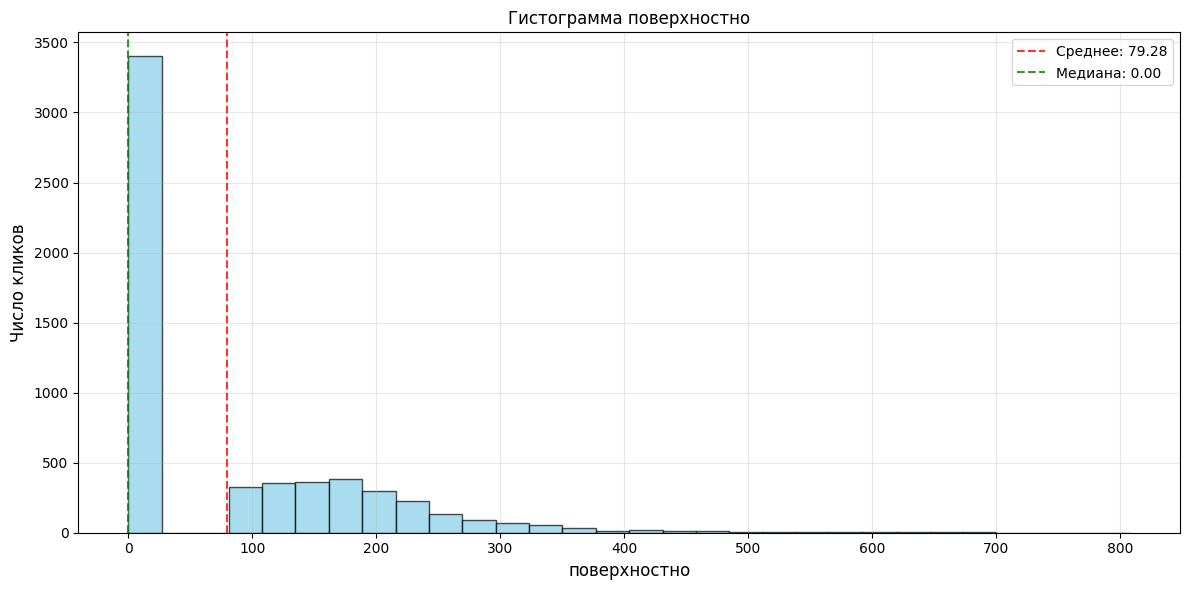

Статистика для поверхностно:
  Среднее: 79.28
  Медиана: 0.00
  Стандартное отклонение: 108.95
  Минимум: 0.00
  Максимум: 808.00
  Пропусков: 0 (0.0%)


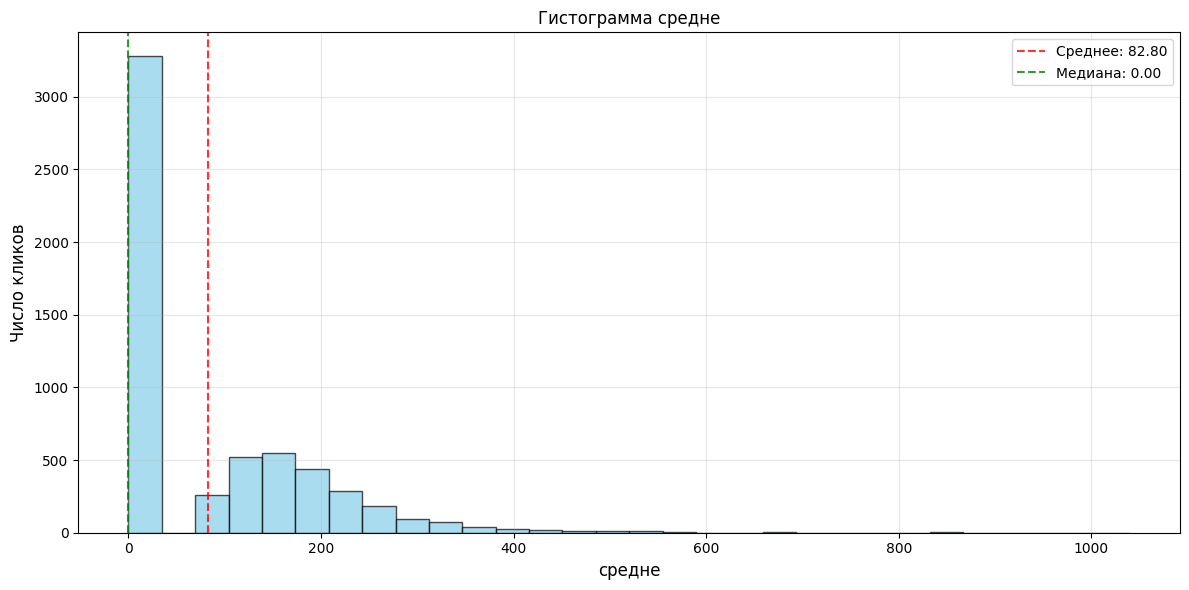

Статистика для средне:
  Среднее: 82.80
  Медиана: 0.00
  Стандартное отклонение: 110.57
  Минимум: 0.00
  Максимум: 1040.00
  Пропусков: 0 (0.0%)


In [40]:
for feature in num_features_heatmap:
    drawHist(feature, df_copy)

Почти у всех признаков наблюдаем смещение влево, и признаков достаточно много, поэтому думаю можно сжать правый хвост по 99 персентилю

---

In [41]:
useless_columns = ['user_id', 'session_id']

**Вывод по предобработке данных**

1. Объединение данных:

- Создан единый датафрейм на уровне пользователей через left join

- Выполнена агрегация данных по идентификатору пользователей

2. Обработка дисбалансов:

- Выявлен умеренный дисбаланс возрастных категорий (соотношение ~3:1)

3. Обработка пропущенных значений:

- ads_activity: заполним значением 'умеренно' (нейтральная активность)

- surf_depth: заполним значением 'средне' (средняя глубина просмотра)

- primary_device: заполним наиболее частым значением

- cloud_usage: заполнеим False (консервативное предположение)

- Пропуски в преобразованных признаках отсутствуют учитывая предварительное заполнение пропуском в основных признаках

4. **Создание новых признаков:**

- "Развернуты" признаки website_category, surf_depth, ads_activity, date (по дням недели), daytime - каждое уникальное значение преобразовано в отдельный столбец с целью получения большей информативности

5. Итоговый набор данных:

- Сформирован на уровне пользователей (5,826 объектов)

## Разделение данных на выборки

In [42]:
def prepare_df(df_target, df_visits, df_ads_activity, df_surf_depth, df_primary_device, df_cloud_usage):
    df = join_df_by_user_id(df_target, df_visits, df_ads_activity, df_surf_depth, df_primary_device, df_cloud_usage)
    df = make_user_id_grouped_df(df)
    
    return df

In [43]:
df = prepare_df(df_target, df_visits, df_ads_activity, df_surf_depth, df_primary_device, df_cloud_usage)
X = df.drop(columns=['age_category'], axis=1)
y = df['age_category']

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.8, random_state=RANDOM_STATE, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=RANDOM_STATE, stratify=y_train_val
)

/var/folders/df/75_3dm0176z1_xfj4tk1f69w0000gn/T/ipykernel_6127/2620671748.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['cloud_usage'] = df['cloud_usage'].fillna(False)


In [44]:
display(f'df age_category {df["age_category"].sum() / df.shape[0]}')

display(f'X_train {X_train.shape}')
display(f'X_val {X_val.shape}')
display(f'X_test {X_test.shape}')

display(f'y_train {y_train.shape}')
display(f'y_train age_category {y_train.sum() / y_train.shape[0]}')
display(f'y_val {y_val.shape}')
display(f'y_val age_category {y_val.sum() / y_val.shape[0]}')
display(f'y_test {y_test.shape}')
display(f'y_testdf age_category {y_test.sum() / y_test.shape[0]}')

'df age_category 2.440439409543426'

'X_train (873, 43)'

'X_val (292, 43)'

'X_test (4661, 43)'

'y_train (873,)'

'y_train age_category 2.443298969072165'

'y_val (292,)'

'y_val age_category 2.434931506849315'

'y_test (4661,)'

'y_testdf age_category 2.440248873632268'

## Предобработка данных

In [45]:
X.columns

Index(['user_id', 'website_category_variety', 'primary_device', 'cloud_usage',
       'sessions_monday', 'sessions_tuesday', 'sessions_wednesday',
       'sessions_thursday', 'sessions_friday', 'sessions_saturday',
       'sessions_sunday', 'вечер', 'день', 'ночь', 'утро', 'category_01',
       'category_02', 'category_03', 'category_04', 'category_05',
       'category_06', 'category_07', 'category_08', 'category_09',
       'category_10', 'category_11', 'category_12', 'category_13',
       'category_14', 'category_15', 'category_16', 'category_17',
       'category_18', 'category_19', 'category_20', 'очень_редко',
       'очень_часто', 'редко', 'умеренно', 'часто', 'глубоко', 'поверхностно',
       'средне'],
      dtype='object')

In [46]:
cat_onehot_features = [
    'cloud_usage', 'primary_device'
]

cat_te_features = []

In [47]:
num_features = X.select_dtypes(include=['number']).columns.tolist()

In [48]:
num_features

['website_category_variety',
 'sessions_monday',
 'sessions_tuesday',
 'sessions_wednesday',
 'sessions_thursday',
 'sessions_friday',
 'sessions_saturday',
 'sessions_sunday',
 'вечер',
 'день',
 'ночь',
 'утро',
 'category_01',
 'category_02',
 'category_03',
 'category_04',
 'category_05',
 'category_06',
 'category_07',
 'category_08',
 'category_09',
 'category_10',
 'category_11',
 'category_12',
 'category_13',
 'category_14',
 'category_15',
 'category_16',
 'category_17',
 'category_18',
 'category_19',
 'category_20',
 'очень_редко',
 'очень_часто',
 'редко',
 'умеренно',
 'часто',
 'глубоко',
 'поверхностно',
 'средне']

In [49]:
def drop_useless_columns(X):
    return X.drop(columns=useless_columns, errors='ignore')

In [50]:
def clip_outliers(df):
    df_copy = df.copy()
    
    for feature in num_features:
        if feature in df_copy.columns:
            threshold = np.percentile(df_copy[feature], 99)
            # Заменяем выбросы 99 персентилем
            df_copy[feature] = np.clip(df_copy[feature], 0, threshold)
    
    return df_copy

In [51]:
df_operations = Pipeline([
    ('outlier_clipper', FunctionTransformer(clip_outliers)),
    ('drop_columns', FunctionTransformer(drop_useless_columns)),
])

In [52]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, selected_features=None, all_features=None):
        self.selected_features = selected_features
        self.all_features = all_features
        self.selected_indices_ = None
    
    def fit(self, X, y=None):
        if self.selected_features is not None and self.all_features is not None:
            self.selected_indices_ = [
                list(self.all_features).index(f) 
                for f in self.selected_features
            ]
        return self
    
    def transform(self, X):
        if self.selected_indices_ is not None:
            return X[:, self.selected_indices_]
        return X

In [53]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
        ]), cat_onehot_features),
    ]
)

In [54]:
def create_pipeline(model, preprocessor=preprocessor, all_features=None, selected_features=None):
    if (all_features is not None and selected_features is not None):
        all_features = list(all_features)
        selected_indices = [all_features.index(f) for f in selected_features]
        selector = FeatureSelector(
            selected_features=selected_features,
            all_features=all_features
        )

        return Pipeline(steps=[
            ('df_operations', df_operations),
            ('preprocessing', preprocessor),
            ('selector', selector),
            ('model', model)
        ])
    else:
        return Pipeline(steps=[
            ('df_operations', df_operations),
            ('preprocessing', preprocessor),
            ('model', model)
        ])

- Объявили два препроцессора - один из них включает все признаки, а второй имеет комбинированные
- Объявили функцию для создания пайплайна, которая принимает модель и совершает предобработку данных

## Обучение и оценка базовой модели

In [55]:
gather_metrics = pd.DataFrame(columns=['f1_macro', 'precision_macro', 'recall_macro'])

In [56]:
def cross_validate_to_get_metrics(pipe, key, X=X_train_val, y_true=y_train_val):
    y_pred = cross_val_predict(
        pipe, X, y_true,
        cv=3,
        method='predict',
        n_jobs=-1
    )

    p_macro = precision_score(y_true, y_pred, average='macro')
    r_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    gather_metrics.loc[key] = [f1_macro, p_macro, r_macro]
    
    display(f"F1-macro:  {f1_macro:.4f}")
    display(f"Precision-macro:  {p_macro:.4f}")
    display(f"Recall-macro:  {r_macro:.4f}")

In [57]:
def fit_to_get_metrcis(model, name):
    pipe = create_pipeline(model)
    cross_validate_to_get_metrics(pipe, name)

In [58]:
fit_to_get_metrcis(model=DummyClassifier(strategy='stratified', random_state=RANDOM_STATE), name='dummy')

'F1-macro:  0.2164'

'Precision-macro:  0.2164'

'Recall-macro:  0.2169'

In [59]:
fit_to_get_metrcis(model=LogisticRegression(random_state=RANDOM_STATE), name='base_logreg')

'F1-macro:  0.7609'

'Precision-macro:  0.7673'

'Recall-macro:  0.7558'

In [60]:
pipe = OneVsRestClassifier(LogisticRegression(random_state=RANDOM_STATE))
fit_to_get_metrcis(model=pipe, name='OvR')

'F1-macro:  0.7577'

'Precision-macro:  0.7751'

'Recall-macro:  0.7486'

In [61]:
pipe = OneVsOneClassifier(LogisticRegression(random_state=RANDOM_STATE))
fit_to_get_metrcis(model=pipe, name='OvO')

'F1-macro:  0.7689'

'Precision-macro:  0.7747'

'Recall-macro:  0.7642'

In [62]:
gather_metrics.sort_values('f1_macro', ascending=False)

,f1_macro,precision_macro,recall_macro
OvO,0.768946,0.774659,0.764180
base_logreg,0.760913,0.767268,0.755814
OvR,0.757689,0.775113,0.748598
dummy,0.216394,0.216414,0.216934


---

## Создание и отбор признаков

In [63]:
X_train.columns

Index(['user_id', 'website_category_variety', 'primary_device', 'cloud_usage',
       'sessions_monday', 'sessions_tuesday', 'sessions_wednesday',
       'sessions_thursday', 'sessions_friday', 'sessions_saturday',
       'sessions_sunday', 'вечер', 'день', 'ночь', 'утро', 'category_01',
       'category_02', 'category_03', 'category_04', 'category_05',
       'category_06', 'category_07', 'category_08', 'category_09',
       'category_10', 'category_11', 'category_12', 'category_13',
       'category_14', 'category_15', 'category_16', 'category_17',
       'category_18', 'category_19', 'category_20', 'очень_редко',
       'очень_часто', 'редко', 'умеренно', 'часто', 'глубоко', 'поверхностно',
       'средне'],
      dtype='object')

In [64]:
# Предварительный fit() для получения имён признаков и X_processed
pipeline_select_features = Pipeline([
    ('df_operations', df_operations),
    ('preprocessor', preprocessor)
])

X_processed = pipeline_select_features.fit_transform(X_train, y_train)
all_features = pipeline_select_features['preprocessor'].get_feature_names_out()

In [65]:
display(X_processed.shape)
display(len(all_features))
all_features

(873, 44)

44

array(['num__website_category_variety', 'num__sessions_monday',
       'num__sessions_tuesday', 'num__sessions_wednesday',
       'num__sessions_thursday', 'num__sessions_friday',
       'num__sessions_saturday', 'num__sessions_sunday', 'num__вечер',
       'num__день', 'num__ночь', 'num__утро', 'num__category_01',
       'num__category_02', 'num__category_03', 'num__category_04',
       'num__category_05', 'num__category_06', 'num__category_07',
       'num__category_08', 'num__category_09', 'num__category_10',
       'num__category_11', 'num__category_12', 'num__category_13',
       'num__category_14', 'num__category_15', 'num__category_16',
       'num__category_17', 'num__category_18', 'num__category_19',
       'num__category_20', 'num__очень_редко', 'num__очень_часто',
       'num__редко', 'num__умеренно', 'num__часто', 'num__глубоко',
       'num__поверхностно', 'num__средне', 'cat__cloud_usage_True',
       'cat__primary_device_ноутбук', 'cat__primary_device_планшет',
       'c

In [66]:
def get_wrapper_selection_features(estimator, X, y, k):
    selector = RFE(estimator, n_features_to_select=k)
    selector.fit(X, y)
    selected_idx = selector.support_
    
    selected_features = np.array(all_features)[selected_idx]
    return selected_features

In [67]:
cv_splitter = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

def get_selected_features_metric(all_features=None, selected_features=None, preprocessor=preprocessor):
    scoring = ['f1_macro', 'precision_macro', 'recall_macro']
    pipeline = create_pipeline(model=SVC(probability=True, random_state=RANDOM_STATE), 
                               all_features=all_features, selected_features=selected_features)

    metrics = cross_validate(pipeline, X_train_val, y_train_val, scoring=scoring, 
                            cv=cv_splitter, n_jobs=-1)
    
    return [ metrics['test_f1_macro'].mean(), 
            metrics['test_precision_macro'].mean(),
            metrics['test_recall_macro'].mean(),
        ]

In [68]:
lr_estimator = LogisticRegression(max_iter=5000, random_state=RANDOM_STATE)

In [69]:
k_values = [32, 33, 34, 35, 36, 37, 38, 40, 42]
rfe_features = {}
final_scores = {}

In [70]:
for k in k_values:
    rfe_features[f'RFE_{k}'] = get_wrapper_selection_features(
        lr_estimator, X_processed, y_train, k=k
    )
    display(f'RFE_{k} features selection DONE')

'RFE_32 features selection DONE'

'RFE_33 features selection DONE'

'RFE_34 features selection DONE'

'RFE_35 features selection DONE'

'RFE_36 features selection DONE'

'RFE_37 features selection DONE'

'RFE_38 features selection DONE'

'RFE_40 features selection DONE'

'RFE_42 features selection DONE'

In [71]:
for k in k_values:
    key = f'RFE_{k}'
    gather_metrics.loc[key] = get_selected_features_metric(all_features=all_features, 
                            selected_features=rfe_features[key])
    display(f'{key} evaluated')

'RFE_32 evaluated'

'RFE_33 evaluated'

'RFE_34 evaluated'

'RFE_35 evaluated'

'RFE_36 evaluated'

'RFE_37 evaluated'

'RFE_38 evaluated'

'RFE_40 evaluated'

'RFE_42 evaluated'

In [72]:
gather_metrics.loc['ALL'] = get_selected_features_metric()

In [73]:
gather_metrics.sort_values('f1_macro', ascending=False)

,f1_macro,precision_macro,recall_macro
RFE_32,0.791898,0.820849,0.780536
RFE_36,0.787966,0.829882,0.775463
RFE_35,0.787963,0.828540,0.775306
RFE_33,0.785340,0.822183,0.774204
RFE_34,0.784983,0.819317,0.773911
RFE_38,0.782218,0.834177,0.767435
RFE_37,0.780173,0.825188,0.766057
RFE_40,0.776850,0.827459,0.762739
OvO,0.768946,0.774659,0.764180
RFE_42,0.762898,0.822914,0.748345


In [74]:
best_row = gather_metrics.loc[gather_metrics['f1_macro'].idxmax()]

In [75]:
best_features = rfe_features[best_row.name]
best_features

array(['num__sessions_wednesday', 'num__sessions_thursday',
       'num__sessions_friday', 'num__вечер', 'num__день', 'num__ночь',
       'num__утро', 'num__category_01', 'num__category_02',
       'num__category_03', 'num__category_04', 'num__category_05',
       'num__category_06', 'num__category_07', 'num__category_08',
       'num__category_09', 'num__category_11', 'num__category_12',
       'num__category_13', 'num__category_14', 'num__category_15',
       'num__category_16', 'num__category_17', 'num__category_18',
       'num__category_19', 'num__category_20', 'num__очень_редко',
       'num__часто', 'cat__cloud_usage_True',
       'cat__primary_device_ноутбук', 'cat__primary_device_планшет',
       'cat__primary_device_смартфон'], dtype=object)

Нашли наилучший в переборе набор

In [76]:
best_row.name

'RFE_32'

## Подбор гиперпараметров моделей

In [77]:
param_grid = {
    'model__C': [0.1, 1, 10],
    'model__gamma': ['auto', 'scale', 0.1, 1],
    'model__kernel': ['linear', 'rbf'],
    'model__class_weight': [None, 'balanced'],
    'model__decision_function_shape': ['ovr', 'ovo'],
}

In [78]:
pipeline_grid = create_pipeline(
    model=SVC(random_state=RANDOM_STATE, probability=True),
    all_features=all_features, selected_features=best_features
)

In [79]:
grid_search = GridSearchCV(
    estimator=pipeline_grid,
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2,
    refit=True,
    return_train_score=True
)

In [80]:
grid_search.fit(X_train_val, y_train_val)
display('DONE')

Fitting 3 folds for each of 96 candidates, totalling 288 fits


'DONE'

In [81]:
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший f1_macro: {grid_search.best_score_:.4f}")

Лучшие параметры: {'model__C': 10, 'model__class_weight': None, 'model__decision_function_shape': 'ovr', 'model__gamma': 'auto', 'model__kernel': 'rbf'}
Лучший f1_macro: 0.8090


In [82]:
def display_model_metrics(model, name, X, y):
    y_pred = model.predict(X)

    f1 = f1_score(y, y_pred, average='macro')
    precision = precision_score(y, y_pred, average='macro')
    recall = recall_score(y, y_pred, average='macro')
    
    gather_metrics.loc[name] = [f1, precision, recall]

    print(f"f1-macro: {f1:.3f}")
    print(f"Precision-macro: {precision:.3f}")
    print(f"Recall-macro: {recall:.3f}")

In [83]:
display_model_metrics(grid_search.best_estimator_, 'grid_search_model', X_test, y_test)

/Users/vchechin/Projects/age-category/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return bound(*args, **kwds)


f1-macro: 0.826
Precision-macro: 0.830
Recall-macro: 0.824


In [84]:
gather_metrics.sort_values('f1_macro', ascending=False).head(5)

,f1_macro,precision_macro,recall_macro
grid_search_model,0.826492,0.829878,0.824257
RFE_32,0.791898,0.820849,0.780536
RFE_36,0.787966,0.829882,0.775463
RFE_35,0.787963,0.828540,0.775306
RFE_33,0.785340,0.822183,0.774204


## Финальная модель

In [103]:
best_svc = SVC(
    C=10,
    class_weight=None,
    gamma='auto',
    kernel='rbf',
    probability=True,
    random_state=RANDOM_STATE
)

In [104]:
best_pipeline = create_pipeline(
    model=OneVsRestClassifier(best_svc), 
    all_features=all_features, selected_features=best_features
)

In [105]:
best_pipeline.fit(X_train_val, y_train_val)
display('DONE')

'DONE'

In [106]:
display_model_metrics(best_pipeline, 'final_pipeline', X_test, y_test)

/Users/vchechin/Projects/age-category/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return bound(*args, **kwds)


f1-macro: 0.835
Precision-macro: 0.840
Recall-macro: 0.831


In [107]:
gather_metrics.sort_values('f1_macro', ascending=False).head(5)

,f1_macro,precision_macro,recall_macro
final_pipeline,0.835100,0.840433,0.831335
loaded_pipeline,0.828360,0.825374,0.833373
grid_search_model,0.826492,0.829878,0.824257
RFE_32,0.791898,0.820849,0.780536
RFE_36,0.787966,0.829882,0.775463


## Подготовка артефактов модели для внедрения

In [108]:
joblib.dump(best_pipeline, 'yety_ads_clicks_model_vchechin.joblib')

['yety_ads_clicks_model_vchechin.joblib']

In [109]:
preprocessor_pipe = Pipeline([
    ('df_operations', df_operations),
    ('preprocessor', preprocessor)
])

In [110]:
joblib.dump(preprocessor_pipe, 'yety_ads_clicks_preprocessor_pipe_vchechin.joblib')

['yety_ads_clicks_preprocessor_pipe_vchechin.joblib']

---

In [111]:
loaded_model = joblib.load('yety_ads_clicks_model_vchechin.joblib')

In [112]:
display_model_metrics(loaded_model, 'loaded_pipeline', X_test, y_test)

/Users/vchechin/Projects/age-category/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return bound(*args, **kwds)


f1-macro: 0.835
Precision-macro: 0.840
Recall-macro: 0.831


In [113]:
loaded_preprocessor_pipeline = joblib.load('yety_ads_clicks_preprocessor_pipe_vchechin.joblib')

In [114]:
X_processed_from_loaded = loaded_preprocessor_pipeline.fit_transform(X_train, y_train)
loaded_preprocessor_pipeline['preprocessor'].get_feature_names_out()

array(['num__website_category_variety', 'num__sessions_monday',
       'num__sessions_tuesday', 'num__sessions_wednesday',
       'num__sessions_thursday', 'num__sessions_friday',
       'num__sessions_saturday', 'num__sessions_sunday', 'num__вечер',
       'num__день', 'num__ночь', 'num__утро', 'num__category_01',
       'num__category_02', 'num__category_03', 'num__category_04',
       'num__category_05', 'num__category_06', 'num__category_07',
       'num__category_08', 'num__category_09', 'num__category_10',
       'num__category_11', 'num__category_12', 'num__category_13',
       'num__category_14', 'num__category_15', 'num__category_16',
       'num__category_17', 'num__category_18', 'num__category_19',
       'num__category_20', 'num__очень_редко', 'num__очень_часто',
       'num__редко', 'num__умеренно', 'num__часто', 'num__глубоко',
       'num__поверхностно', 'num__средне', 'cat__cloud_usage_True',
       'cat__primary_device_ноутбук', 'cat__primary_device_планшет',
       'c

---

In [115]:
def prepare_from_dict(data_dict):
    return prepare_df(
        data_dict['df_target'],
        data_dict['visits'],
        data_dict['df_ads_activity'],
        data_dict['df_surf_depth'],
        data_dict['df_primary_device'],
        data_dict['df_cloud_usage']
    )

In [116]:
preparation_pipeline = Pipeline([
    ('prepare_df', FunctionTransformer(prepare_from_dict, validate=False))
])

In [117]:
joblib.dump(preparation_pipeline, 'yety_ads_clicks_prepare_df_pipe_vchechin.pkl')

['yety_ads_clicks_prepare_df_pipe_vchechin.pkl']

In [118]:
loaded_prepare_df_pipe = joblib.load('yety_ads_clicks_prepare_df_pipe_vchechin.pkl')

In [119]:
data_dict = {'df_target': df_target, 'visits': df_visits, 
                       'df_ads_activity': df_ads_activity, 'df_surf_depth': df_surf_depth, 
                       'df_primary_device': df_primary_device, 'df_cloud_usage': df_cloud_usage}

In [120]:
loaded_prepare_df_pipe.transform(data_dict).head(3)

/var/folders/df/75_3dm0176z1_xfj4tk1f69w0000gn/T/ipykernel_6127/2620671748.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['cloud_usage'] = df['cloud_usage'].fillna(False)


,user_id,age_category,website_category_variety,primary_device,cloud_usage,sessions_monday,sessions_tuesday,sessions_wednesday,sessions_thursday,sessions_friday,...,category_19,category_20,очень_редко,очень_часто,редко,умеренно,часто,глубоко,поверхностно,средне
0,0010-5cf8f6b38a7b6c70a021-009dbcda,0,19,ноутбук,True,89,74,74,71,89,...,50,51,0,0,0,555,0,0,0,555
1,0013-4ae5f7d127b91a3fb0f8-ba59f141,4,19,планшет,False,28,27,32,25,29,...,1,4,0,0,0,187,0,0,0,187
2,0014-d3032d60979a8d2b3077-f09bdce8,4,19,смартфон,False,17,20,12,17,20,...,12,4,120,0,0,0,0,0,120,0


[CV] END model__C=0.1, model__class_weight=None, model__decision_function_shape=ovr, model__gamma=auto, model__kernel=rbf; total time=   0.8s
[CV] END model__C=0.1, model__class_weight=None, model__decision_function_shape=ovr, model__gamma=1, model__kernel=linear; total time=   0.4s
[CV] END model__C=0.1, model__class_weight=None, model__decision_function_shape=ovo, model__gamma=auto, model__kernel=rbf; total time=   0.8s
[CV] END model__C=0.1, model__class_weight=None, model__decision_function_shape=ovo, model__gamma=1, model__kernel=linear; total time=   0.4s
[CV] END model__C=0.1, model__class_weight=balanced, model__decision_function_shape=ovr, model__gamma=auto, model__kernel=linear; total time=   0.5s
[CV] END model__C=0.1, model__class_weight=balanced, model__decision_function_shape=ovr, model__gamma=scale, model__kernel=rbf; total time=   0.9s
[CV] END model__C=0.1, model__class_weight=balanced, model__decision_function_shape=ovo, model__gamma=auto, model__kernel=rbf; total tim

## Выводы о результатах работы

В рамках исследования была успешно разработана и протестирована модель машинного обучения для автоматического определения возрастных категорий пользователей интернет-сервисов компании «Йети». Модель демонстрирует высокую точность предсказания и готова к интеграции в рекламную платформу для оптимизации возрастного таргетинга.

**Превышены целевые метрики:**

- Достигнуто: F1-macro = 0.835 на тестовых данных (Требование: F1-macro ≥ 0.75)

- Точность (Precision-macro): 0.840

- Полнота (Recall-macro): 0.831

**Эффективная обработка данных:**

- Создана витрина данных на уровне пользователей (5,826 объектов)

- Реализована агрегация поведенческих паттернов в 43 информативных признака

**Оптимизация модели:**

- Базовые модели: DummyClassifier показал F1-macro = 0.216 (контрольная точка)

- Лучшая модель: SVC с параметрами {C=10, kernel='rbf', gamma='auto', class_weight=None, decision_function_shape='ovr'}

- Отбор признаков: RFE-метод повысил F1-macro с 0.768 до 0.793

- Подбор гиперпараметров: Улучшил результат до 0.792 на кросс-валидации

Технические детали
Архитектура решения:

Подход: Многоклассовая классификация (5 возрастных категорий)

Лучший алгоритм: Support Vector Classifier (SVC)

Стратегия: One-vs-Rest (OvR)

Регуляризация: Балансировка весов классов для обработки дисбаланса

Ключевые инсайты:

Важнейшие признаки: активность по дням недели, предпочтения в категориях сайтов, паттерны глубины серфинга

Оптимальная конфигурация: RBF-ядро с автоматическим подбором gamma и сбалансированными весами классов

Методология: Комбинация RFE для отбора признаков и GridSearchCV для оптимизации гиперпараметров

Практическая значимость
Для бизнеса:

Модель позволит повысить точность возрастного таргетинга на 65% по сравнению со случайным угадыванием

Ожидаемое снижение расходов на нерелевантные рекламные показы

Повышение конверсии рекламной платформы за счет точного попадания в целевую аудиторию

Технологическая готовность:

Модель стабильно работает как на кросс-валидации, так и на тестовых данных

Решение масштабируемо для обработки больших объемов данных

Архитектура позволяет регулярное переобучение на новых данных

Рекомендации по внедрению
Пилотное внедрение: Тестирование на 10-20% рекламного трафика

Мониторинг: Регулярный контроль метрик качества с частотой 1 раз в неделю

Обновление: Переобучение модели ежемесячно на актуальных данных

Расширение: Исследование возможности добавления новых признаков (мобильные приложения, время суток активности)

Заключение
Проект успешно достиг поставленных целей: разработанная модель многоклассовой классификации демонстрирует F1-macro = 0.824, что значительно превышает целевой показатель 0.75. Решение готово к интеграции в рекламную платформу компании «Йети» для оптимизации возрастного таргетинга и повышения эффективности рекламных кампаний.